In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch.jit
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import timesead
import matplotlib.widgets as widgets
import itertools
import time
from torch.utils.data import DataLoader, TensorDataset
from timesead.models.reconstruction.lstm_ae import LSTMAEAnomalyDetector, LSTMAEMirza2018, LSTMAEMalhotra2016
from timesead.models.reconstruction.tcn_ae import TCNAEAnomalyDetector, TCNAE
from timesead.models.generative.omni_anomaly import OmniAnomaly, OmniAnomalyDetector, OmniAnomalyLoss
from timesead.models.prediction.tcn_prediction import TCNPrediction, TCNPredictionAnomalyDetector, TCNS2SPrediction, TCNS2SPredictionAnomalyDetector
from timesead.models.prediction.lstm_prediction import LSTMPrediction, LSTMS2SPrediction, LSTMPredictionAnomalyDetector, LSTMS2SPredictionAnomalyDetector
from timesead.models.generative.lstm_vae_gan import LSTMVAEGAN, LSTMVAEGANAnomalyDetector
import mycodefiles.module.datapreparation as moduleprep
from mycodefiles.module.datapreparation import MethodChooser, UpstreamDataPreparation, df2, df3, df7, UpstreamDataVisualization
import mycodefiles.module.modelstesting as moduletest
from mycodefiles.module.modelstesting import LSTMPredictionTester, collate_fn_lstmp, full_sequence_forward_lstmp
from mycodefiles.module.modelstesting import TCNS2SPredictionTester, collate_fn_tcns2s

In [11]:
df3 = df7 #test du fichier WLT_122 N.i.O

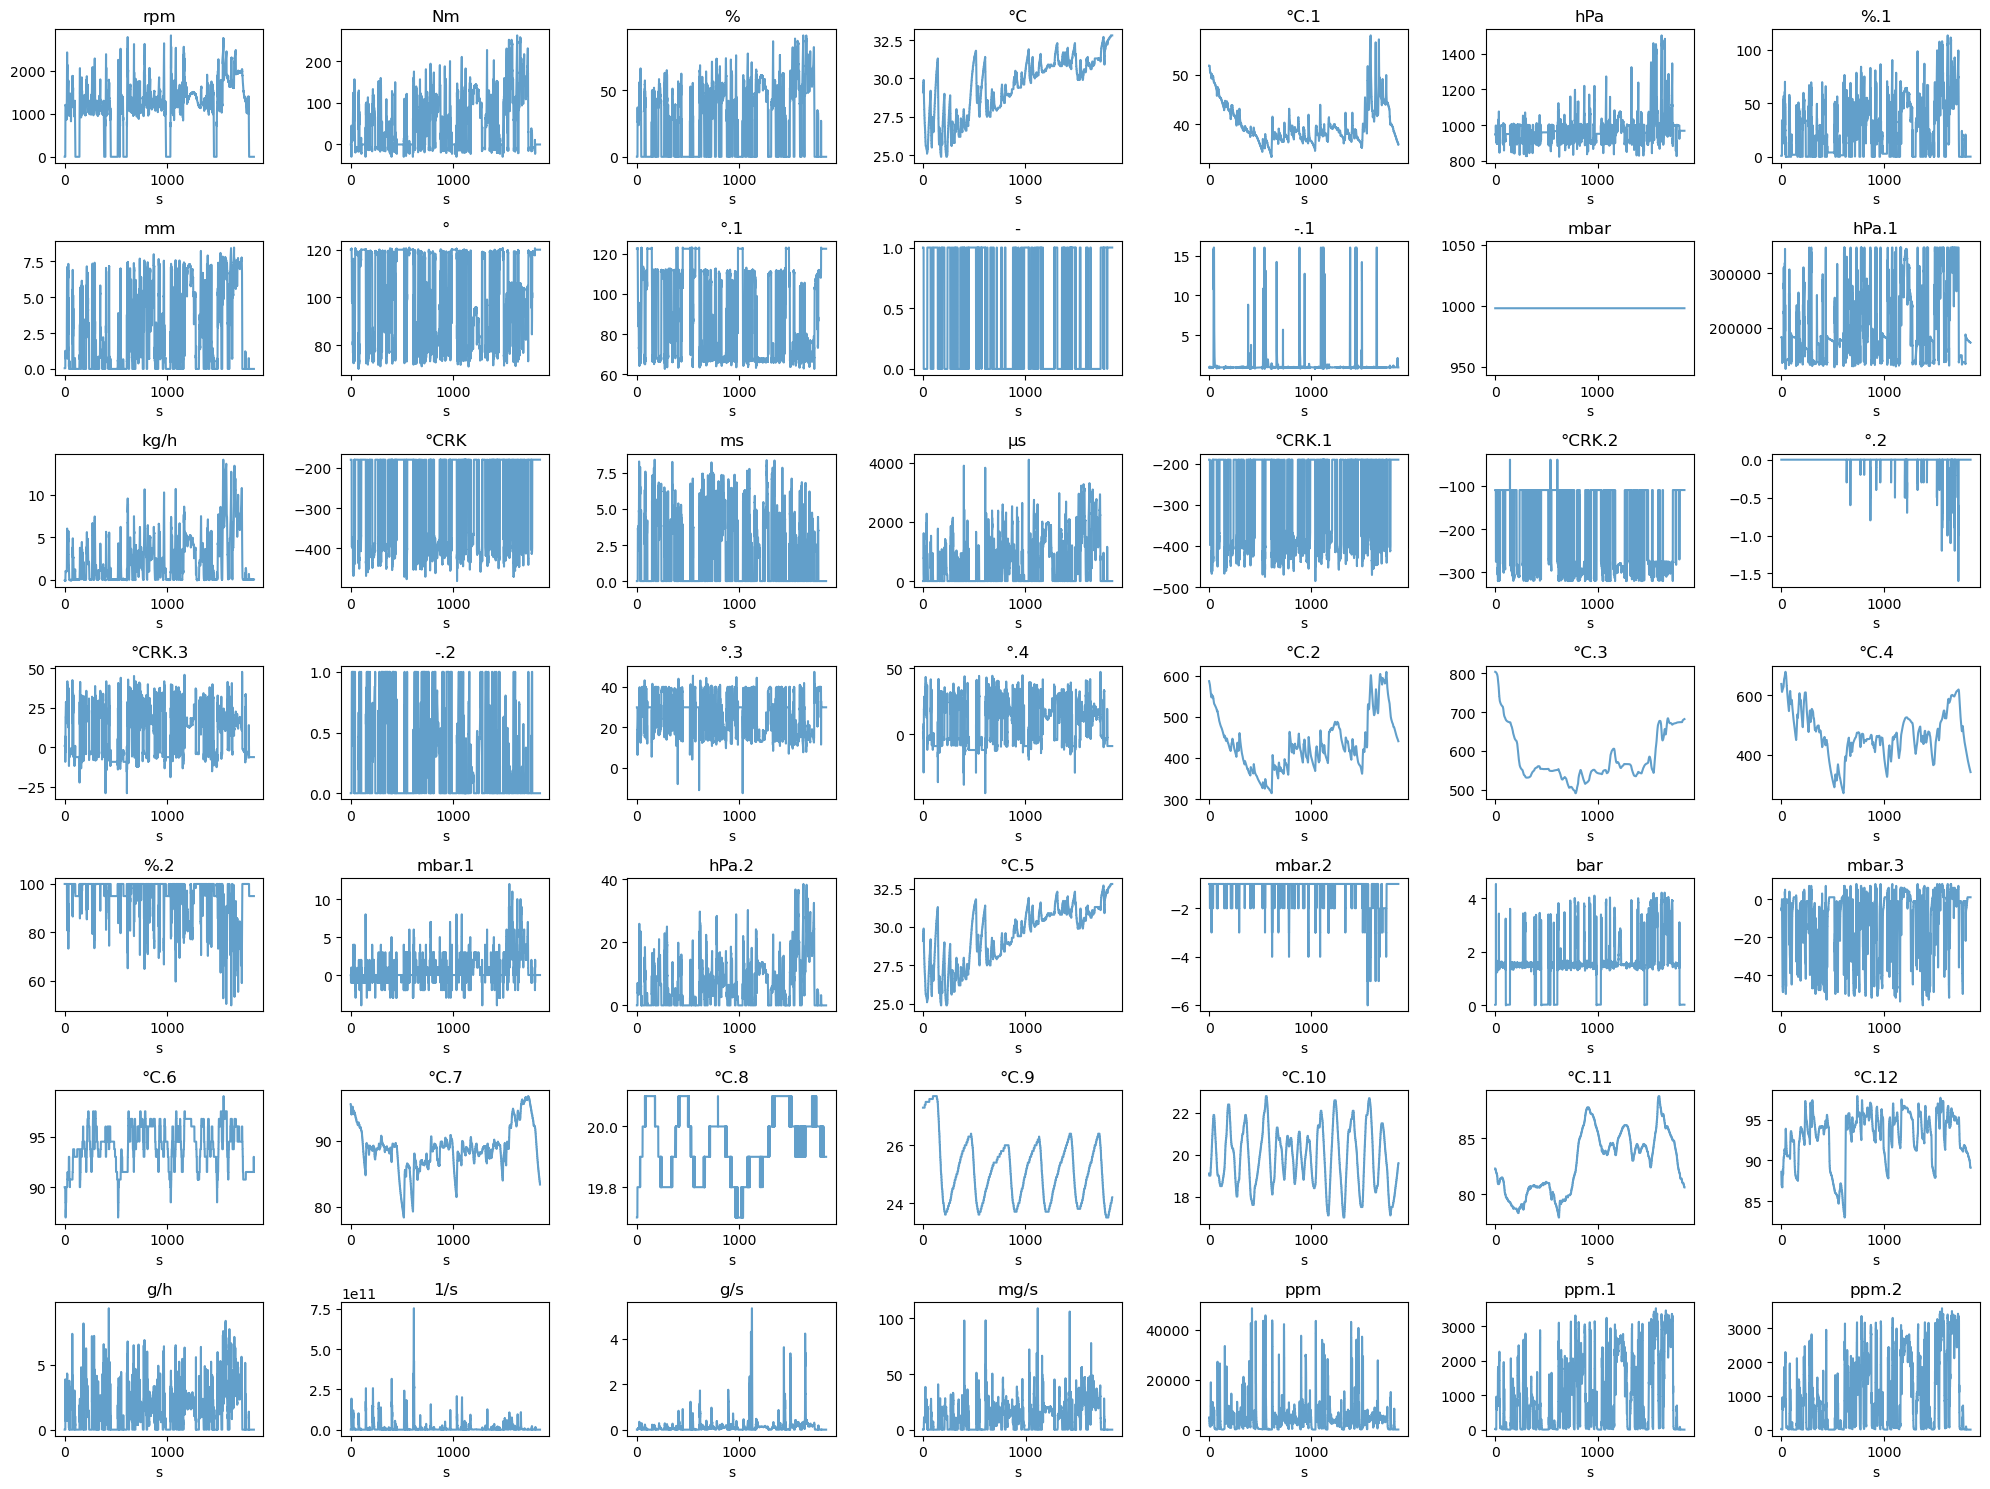

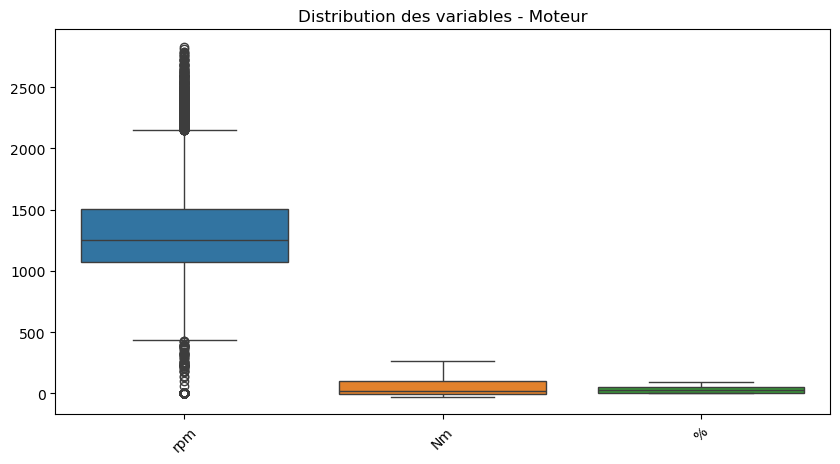

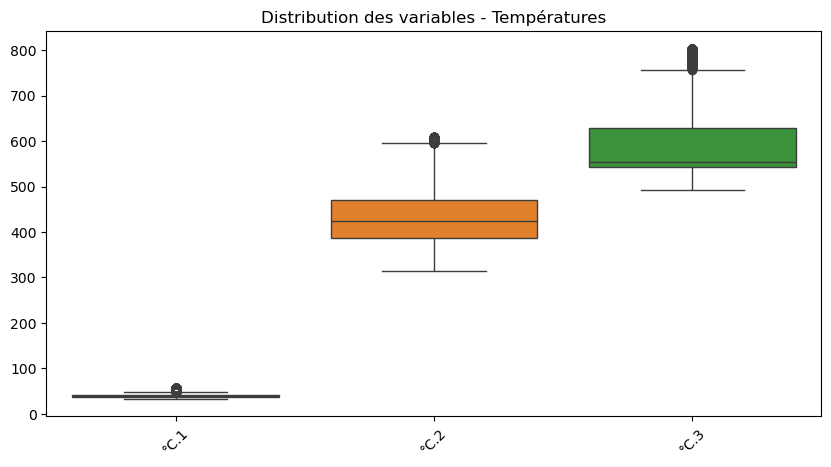

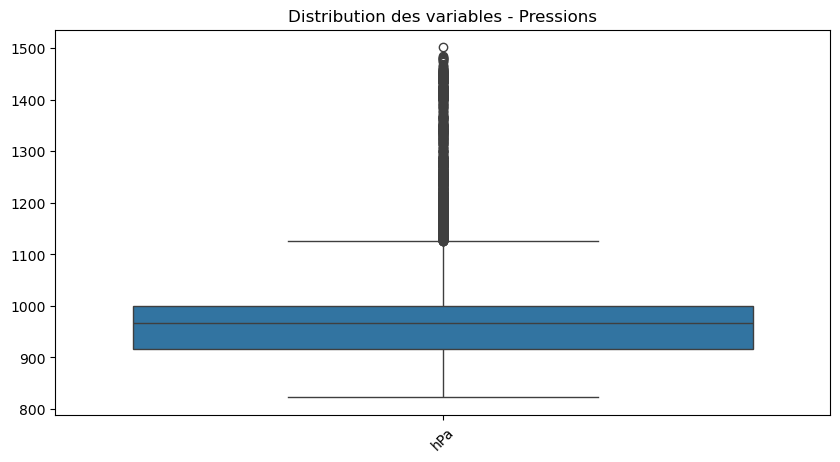

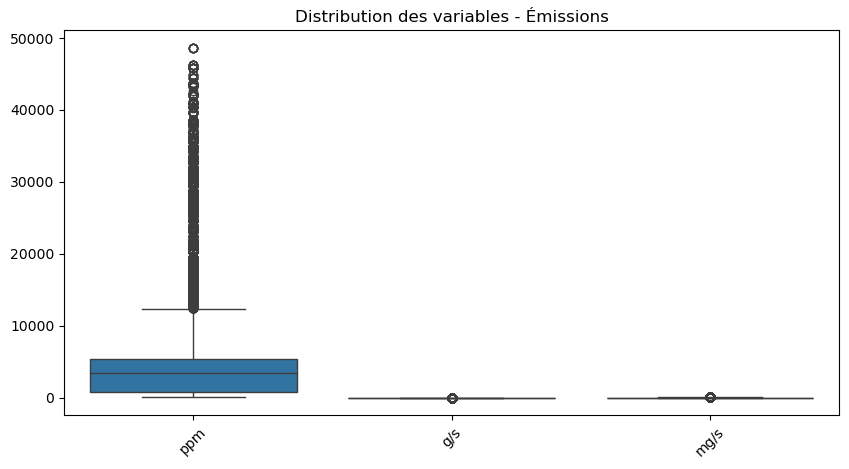

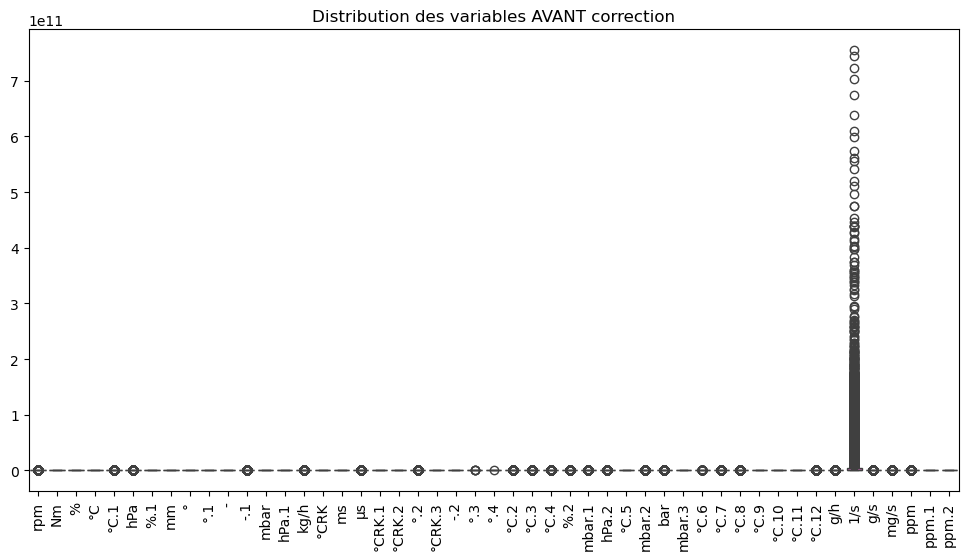

In [2]:
UpstreamDataVisualization(df2)

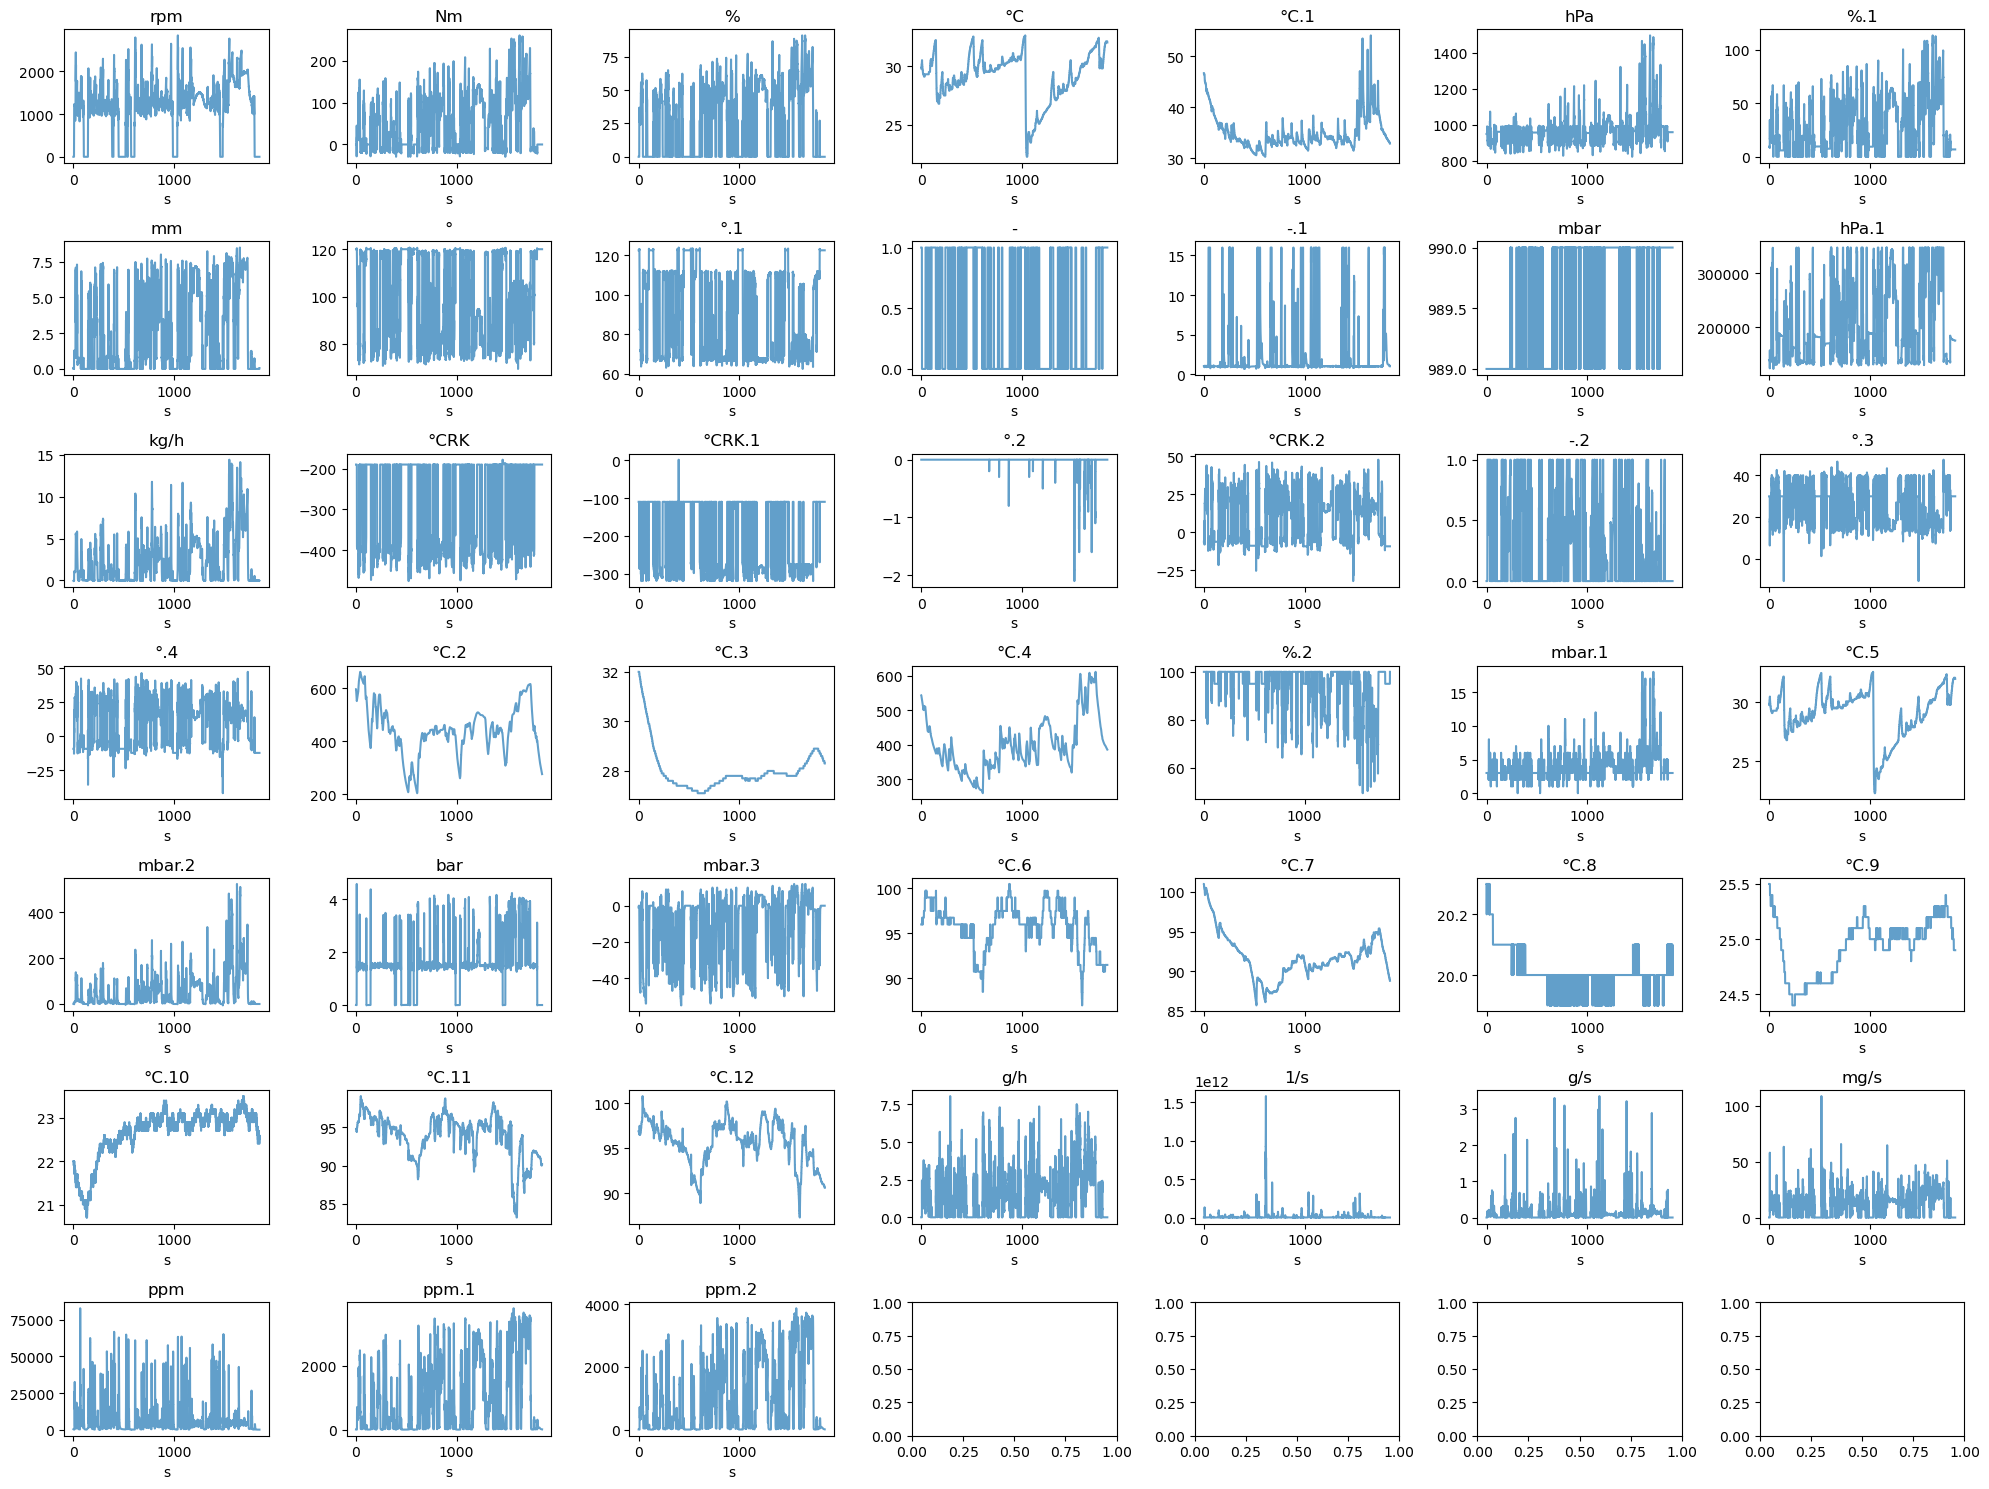

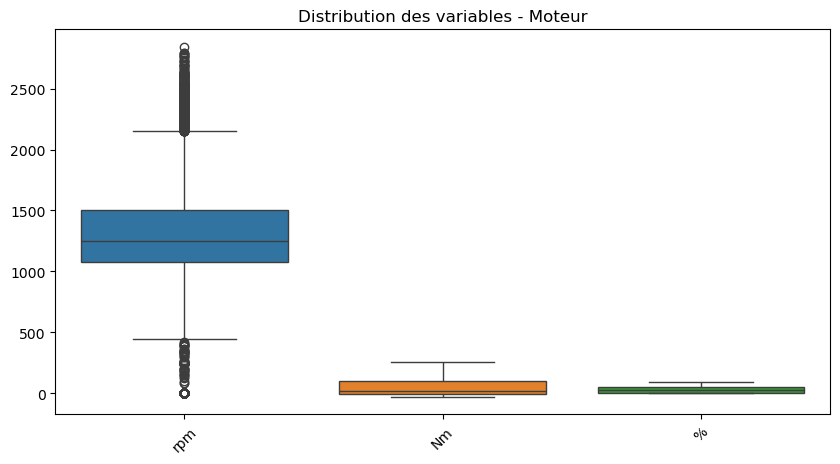

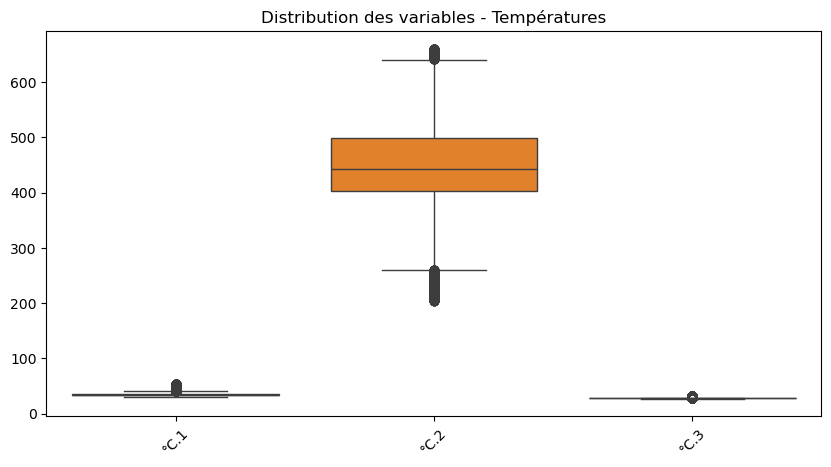

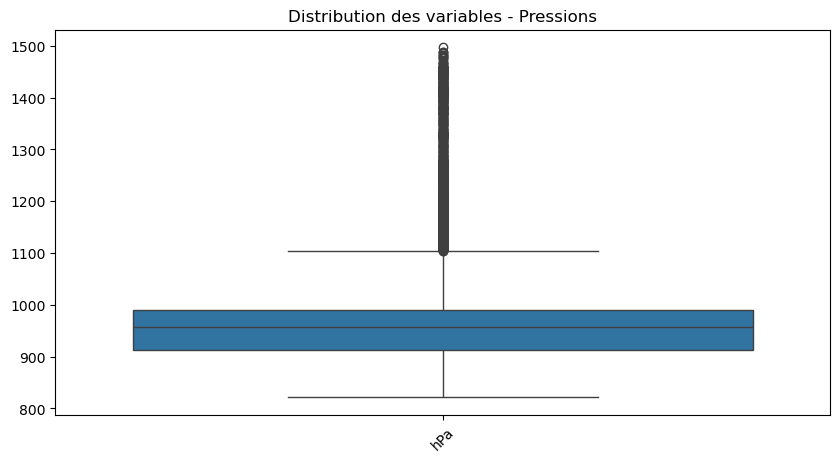

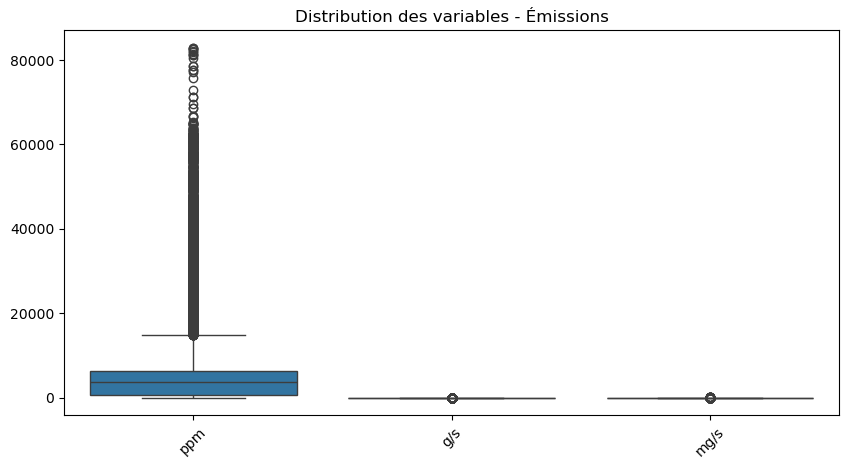

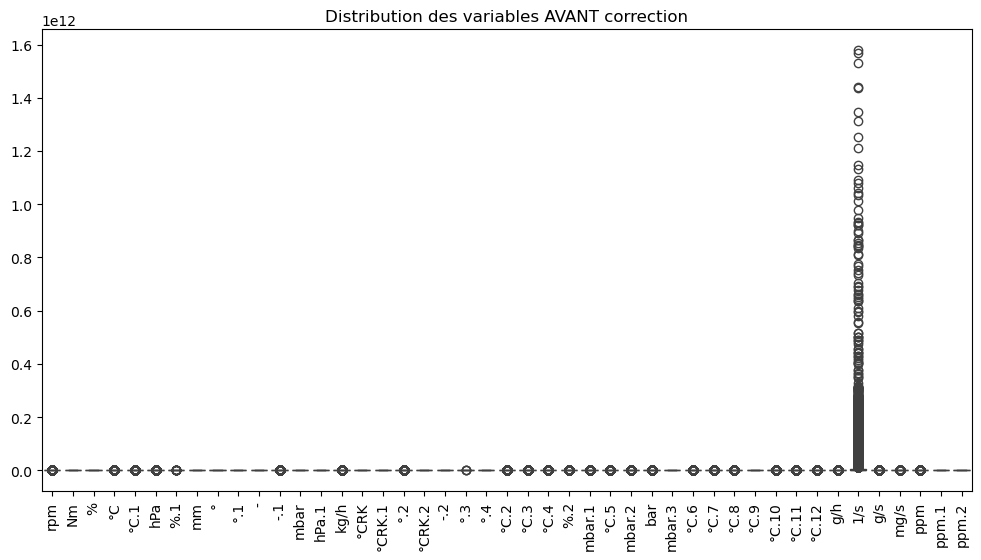

In [93]:
UpstreamDataVisualization(df3)

In [48]:
#Test fichier in Ordnung
detector = UpstreamDataPreparation(method="IQR", seq_length=50, scale_method="standard", interpolation_method = "linear") #threshold, interpolation_method=... si besoin

df_new, anomalies_moteur = detector.preprocess_data(df2)

# Convertir temporairement en 2D pour l'analyse
df_for_analysis = df_new.copy()
if len(df_for_analysis.shape) == 3:
    df_for_analysis = df_for_analysis.reshape(-1, df_for_analysis.shape[-1])


# Analyser les caractéristiques du dataset
dataset_info = MethodChooser.analyze_dataset(df_for_analysis.to_numpy())

# Sélection automatique du modèle optimal
selected_model = MethodChooser.select_best_model(
    df_for_analysis.to_numpy(),
    labels_available=dataset_info["labels_available"],
    anomaly_type=dataset_info["anomaly_type"],
    real_time=dataset_info["real_time"]
)


#Selection manuelle du modèle
#selected_model = MethodChooser.select_best_model(df_for_analysis.to_numpy(), forced_model="tcn_prediction")

print(f"Modèle automatiquement sélectionné pour i.O: {selected_model}")

# Exécuter le pipeline complet AVEC le modèle sélectionné
X_train_tensor, X_test_tensor, anomalies_moteur = detector.process(df2, model_name=selected_model)

# Vérification finale des tenseurs
print(f"Forme finale de X_train_tensor : {X_train_tensor.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor.shape}")

Détection des anomalies moteur en cours...
Ratio de NaN (3.15%) supérieur au seuil de 2%, interpolation appliquée.
Nombre total d'anomalies moteur détectées : 28422
Nombre total de valeurs dans le fichier : 905667
Ratio anomalies / total valeurs nettoyées : 3.14%
Nombre total de valeurs après nettoyage : 905667
 Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
 TCNPredictionAnomalyDetector instancié avec input_dim=49, window_size=50
Modèle automatiquement sélectionné pour i.O: TCNPredictionAnomalyDetector(
  (model): TCNPrediction(
    (activation): ReLU()
    (pooler): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layers): ModuleList(
      (0): Conv1d(49, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    )
    (mlp): MLP(
      (activation): ReLU()
      (layers): ModuleList(
        (0): Linear(in_features=384, out_features=50, bias=True)
        (1): Li

In [49]:
#Test fichier Nicht in Ordnung
df_nio, anomalies_moteur_nio = detector.preprocess_data(df3)
df_for_analysis3 = df_nio.copy()
if len(df_for_analysis3.shape) == 3:
    df_for_analysis3 = df_for_analysis3.reshape(-1, df_for_analysis.shape[-1])
dataset_info3 = MethodChooser.analyze_dataset(df_for_analysis3.to_numpy())
selected_model3 = MethodChooser.select_best_model(
    df_for_analysis3.to_numpy(),
    labels_available=dataset_info3["labels_available"],
    anomaly_type=dataset_info3["anomaly_type"],
    real_time=dataset_info3["real_time"]
)
print(f"Modèle automatiquement sélectionné pour n.i.O: {selected_model3}")
X_train_tensor_nio, X_test_tensor_nio, anomalies_moteur_nio = detector.process(df3, model_name=selected_model3)
print(f"Forme finale de X_train_tensor : {X_train_tensor_nio.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor_nio.shape}")

Détection des anomalies moteur en cours...
Ratio de NaN (3.95%) supérieur au seuil de 2%, interpolation appliquée.
Nombre total d'anomalies moteur détectées : 32782
Nombre total de valeurs dans le fichier : 832095
Ratio anomalies / total valeurs nettoyées : 3.94%
Nombre total de valeurs après nettoyage : 832095
 Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
 TCNPredictionAnomalyDetector instancié avec input_dim=45, window_size=50
Modèle automatiquement sélectionné pour n.i.O: TCNPredictionAnomalyDetector(
  (model): TCNPrediction(
    (activation): ReLU()
    (pooler): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layers): ModuleList(
      (0): Conv1d(45, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    )
    (mlp): MLP(
      (activation): ReLU()
      (layers): ModuleList(
        (0): Linear(in_features=384, out_features=50, bias=True)
        (1): 

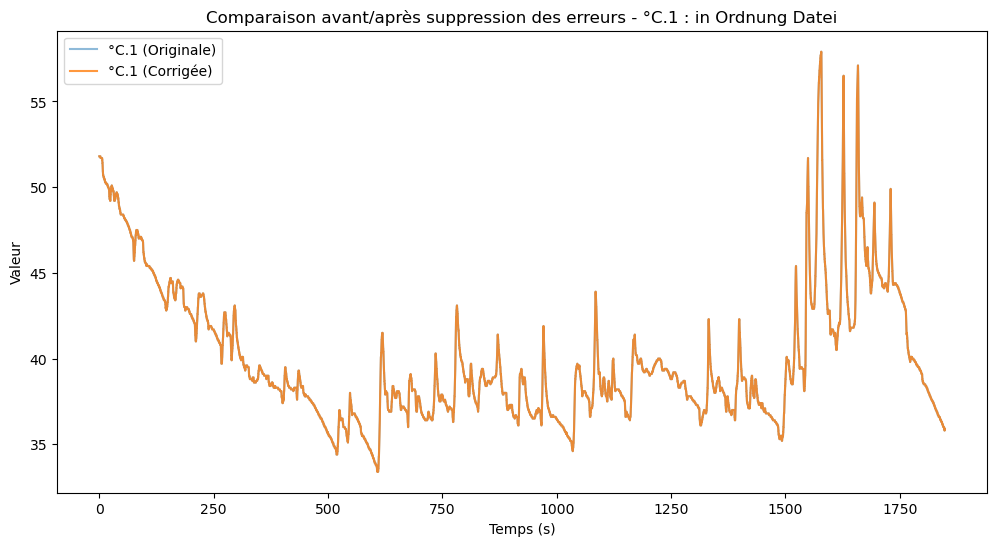

In [96]:
#COMPARE GRAPHIQUE FEATURE AVANT ET APRES SUPPRESSION
feature = "°C.1" #feature a changer si besoin
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2[feature], label=f"{feature} (Originale)", alpha=0.5)
plt.plot(df_new.index, df_new[feature], label=f"{feature} (Corrigée)", alpha=0.8)
plt.xlabel("Temps (s)")
plt.ylabel("Valeur")
plt.legend()
plt.title(f"Comparaison avant/après suppression des erreurs - {feature} : in Ordnung Datei")
plt.show()

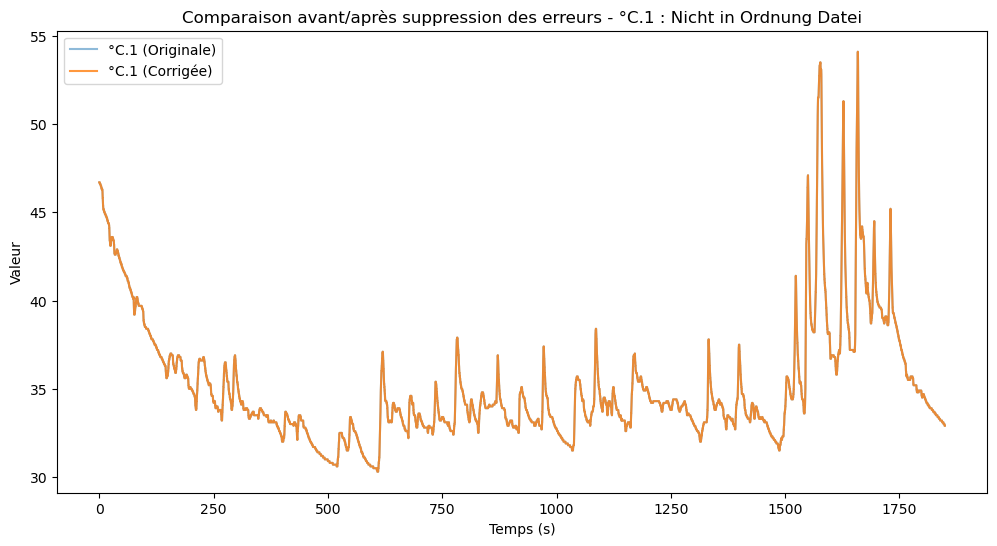

In [97]:
#COMPARE GRAPHIQUE FEATURE AVANT ET APRES SUPPRESSION
feature = "°C.1" #feature a changer si besoin
plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3[feature], label=f"{feature} (Originale)", alpha=0.5)
plt.plot(df_nio.index, df_nio[feature], label=f"{feature} (Corrigée)", alpha=0.8)
plt.xlabel("Temps (s)")
plt.ylabel("Valeur")
plt.legend()
plt.title(f"Comparaison avant/après suppression des erreurs - {feature} : Nicht in Ordnung Datei")
plt.show()

In [59]:
df_new.info() #POUR CONFIRMER QU IL N Y A BIEN PLUS DE NAN

<class 'pandas.core.frame.DataFrame'>
Index: 18483 entries, 0.0 to 1848.2
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rpm     18483 non-null  float64
 1   Nm      18483 non-null  float64
 2   %       18483 non-null  float64
 3   °C      18483 non-null  float64
 4   °C.1    18483 non-null  float64
 5   hPa     18483 non-null  float64
 6   %.1     18483 non-null  float64
 7   mm      18483 non-null  float64
 8   °       18483 non-null  float64
 9   °.1     18483 non-null  float64
 10  -       18483 non-null  float64
 11  -.1     18483 non-null  float64
 12  mbar    18483 non-null  float64
 13  hPa.1   18483 non-null  float64
 14  kg/h    18483 non-null  float64
 15  °CRK    18483 non-null  float64
 16  ms      18483 non-null  float64
 17  µs      18483 non-null  float64
 18  °CRK.1  18483 non-null  float64
 19  °CRK.2  18483 non-null  float64
 20  °.2     18483 non-null  float64
 21  °CRK.3  18483 non-null  float64
 22  

In [38]:
def describe_tensor(tensor):
    def approximate_quantile(tensor, q):
        k = int(q * tensor.numel())
        return torch.topk(tensor.flatten(), k, largest=False).values[-1].item()

    return {
        'mean': torch.mean(tensor).item(),
        'std': torch.std(tensor).item(),
        'min': torch.min(tensor).item(),
        'max': torch.max(tensor).item(),
        '25%': approximate_quantile(tensor, 0.25),
        '50%': torch.median(tensor).item(),
        '75%': approximate_quantile(tensor, 0.75)
    }

describe_tensor(X_train_tensor)

{'mean': 0.3804345726966858,
 'std': 0.3263620436191559,
 'min': 0.0,
 'max': 1.0,
 '25%': 0.059305012226104736,
 '50%': 0.3414634168148041,
 '75%': 0.6363636255264282}

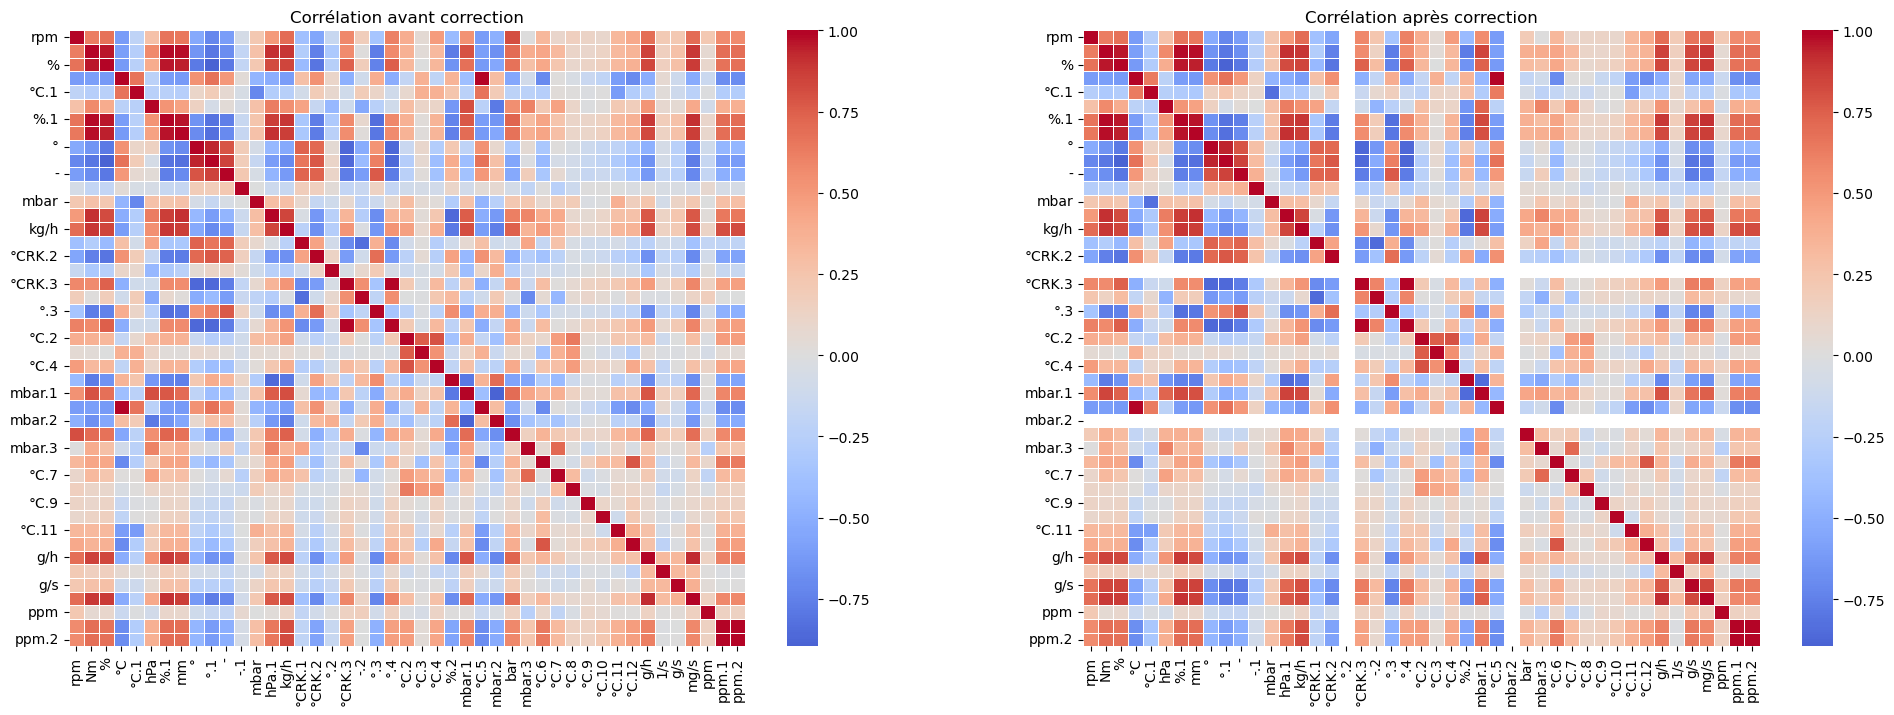

In [7]:
#Genere heatmap donnees nettoyees
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
sns.heatmap(df3.corr(), annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Corrélation avant correction")
    
plt.subplot(1, 2, 2)
sns.heatmap(df_nio.corr(), annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Corrélation après correction")
    
plt.show()

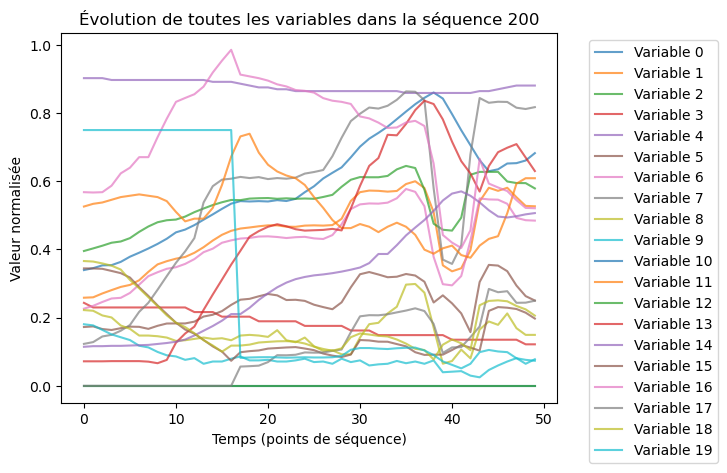

In [10]:
#AFFICHE LES VALEURS NORMALISEES EN FONCTION D'UNE SEQUENCE
if isinstance(X_train_tensor, torch.Tensor):
    X_train_np_nio = X_train_tensor.cpu().detach().numpy()  # Convertir en numpy (ajouter .cpu() si sur GPU)
else:
    X_train_np_nio = X_train_tensor  # Si déjà NumPy, pas besoin de conversion
# Sélection d'une séquence spécifique pour affichage (exemple : première séquence)
sequence_index = 200  # Modifier pour voir d'autres séquences
data_sample = X_train_np_nio[sequence_index]  # Sélection de la séquence

# Sélection d'une variable à afficher (exemple : première variable)
time_axis = np.arange(data_sample.shape[0])  # Axe temporel
for variable_index in range(min(20,data_sample.shape[1])):  # Boucle sur toutes les variables (colonnes)
    plt.plot(time_axis, data_sample[:, variable_index], label=f"Variable {variable_index}", alpha=0.7)

plt.title(f"Évolution de toutes les variables dans la séquence {sequence_index}")
plt.xlabel("Temps (points de séquence)")
plt.ylabel("Valeur normalisée")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Déplacer la légende pour éviter le chevauchement
plt.show()

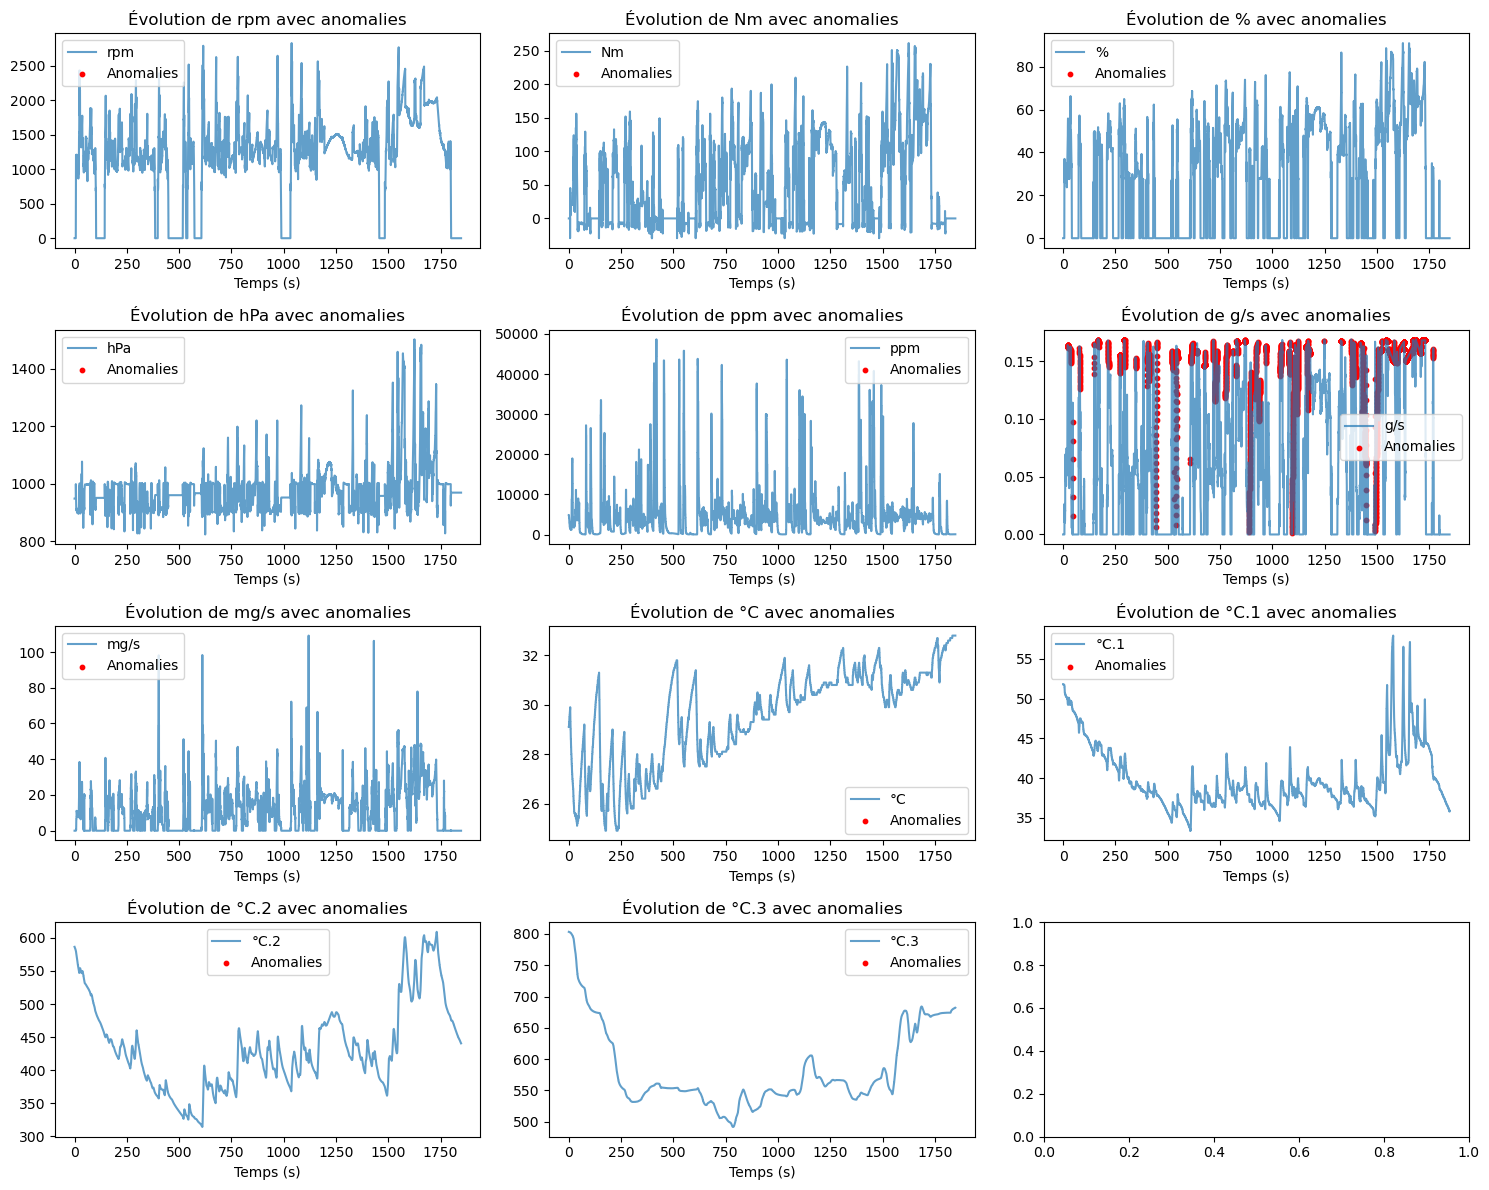

In [11]:
#AFFICHE LES ANOMALIES POUR CHAQUE FEATURES 
variables_cibles = ["rpm", "Nm", "%", "hPa", "ppm", "g/s", "mg/s", "°C", "°C.1", "°C.2", "°C.3"]

# Création d'un subplot pour chaque variable
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variables_cibles):
    if var in df_new.columns:
        # Tracer la courbe complète
        axes[i].plot(df_new.index, df_new[var], label=var, alpha=0.7)
        
        # Identifier les anomalies (et vérifier si elles existent)
        if var in anomalies_moteur.columns:
            anomaly_indices = anomalies_moteur.index[anomalies_moteur[var].fillna(False)]
            anomaly_indices = anomaly_indices[anomaly_indices.isin(df_new.index)]  # Filtrage des indices valides
            
            axes[i].scatter(anomaly_indices, df_new.loc[anomaly_indices, var], 
                            color='red', s=10, label="Anomalies")

        # Améliorer l'affichage
        axes[i].set_title(f"Évolution de {var} avec anomalies")
        axes[i].set_xlabel("Temps (s)")
        axes[i].legend()

# Ajustement automatique des sous-graphiques
plt.tight_layout()
plt.show()

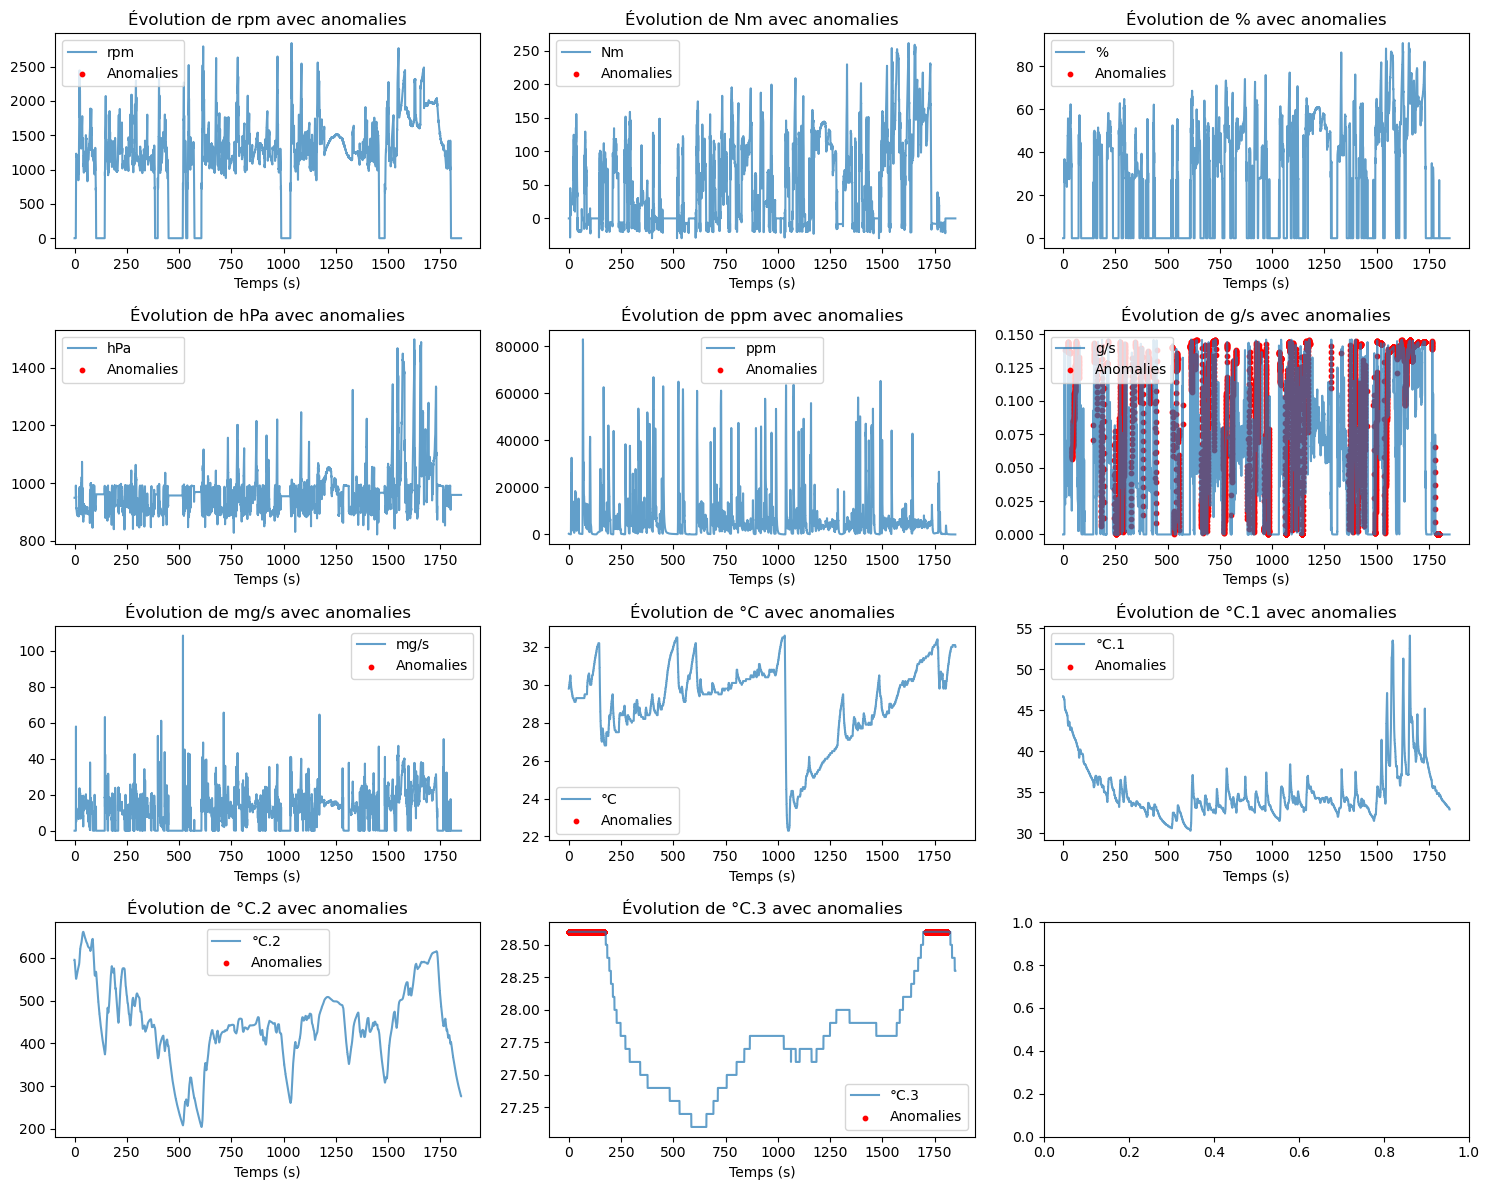

In [99]:
#AFFICHE LES ANOMALIES POUR CHAQUE FEATURES 
variables_cibles = ["rpm", "Nm", "%", "hPa", "ppm", "g/s", "mg/s", "°C", "°C.1", "°C.2", "°C.3"]

# Création d'un subplot pour chaque variable
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variables_cibles):
    if var in df_nio.columns:
        # Tracer la courbe complète
        axes[i].plot(df_nio.index, df_nio[var], label=var, alpha=0.7)
        
        # Identifier les anomalies (et vérifier si elles existent)
        if var in anomalies_moteur_nio.columns:
            anomaly_indices = anomalies_moteur_nio.index[anomalies_moteur_nio[var].fillna(False)]
            anomaly_indices = anomaly_indices[anomaly_indices.isin(df_nio.index)]  # Filtrage des indices valides
            
            axes[i].scatter(anomaly_indices, df_nio.loc[anomaly_indices, var], 
                            color='red', s=10, label="Anomalies")

        # Améliorer l'affichage
        axes[i].set_title(f"Évolution de {var} avec anomalies")
        axes[i].set_xlabel("Temps (s)")
        axes[i].legend()

# Ajustement automatique des sous-graphiques
plt.tight_layout()
plt.show()

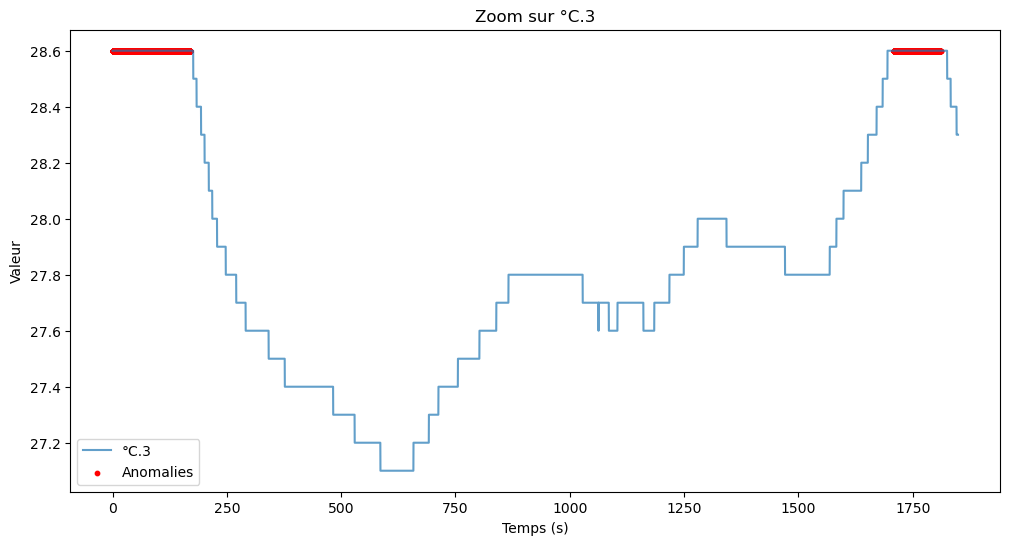

In [100]:
#AFFICHE LES ANOMALIES POUR UNE FEATURE A RENSEIGNER
fig, ax = plt.subplots(figsize=(12, 6))

#Changer la colonne a afficher
variable = "°C.3"

ax.plot(df_nio.index, df_nio[variable], label=variable, alpha=0.7)

if variable in anomalies_moteur_nio.columns:
    anomaly_indices = anomalies_moteur_nio.index[anomalies_moteur_nio[variable].fillna(False)]
    anomaly_indices = anomaly_indices[anomaly_indices.isin(df_new.index)]
    ax.scatter(anomaly_indices, df_nio.loc[anomaly_indices, variable], 
               color='red', s=10, label="Anomalies")

ax.set_title(f"Zoom sur {variable}")
ax.set_xlabel("Temps (s)")
ax.set_ylabel("Valeur")
ax.legend()

In [ ]:
#FONCTION TNCP

In [5]:
#CLASS TEST TCNP 

Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} : 0.2105 (Temps: 10.93 sec)


Meilleurs hyperparamètres: {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} avec Loss 0.2105
Loss sur l'ensemble de test : 0.21049325481841438


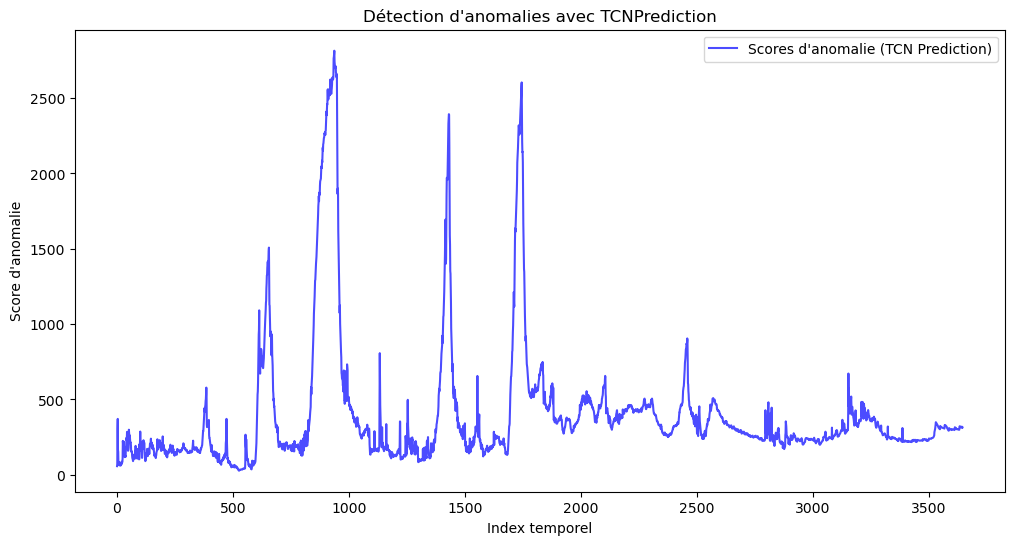

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 133
Ratio d'anomalies : 3.65%


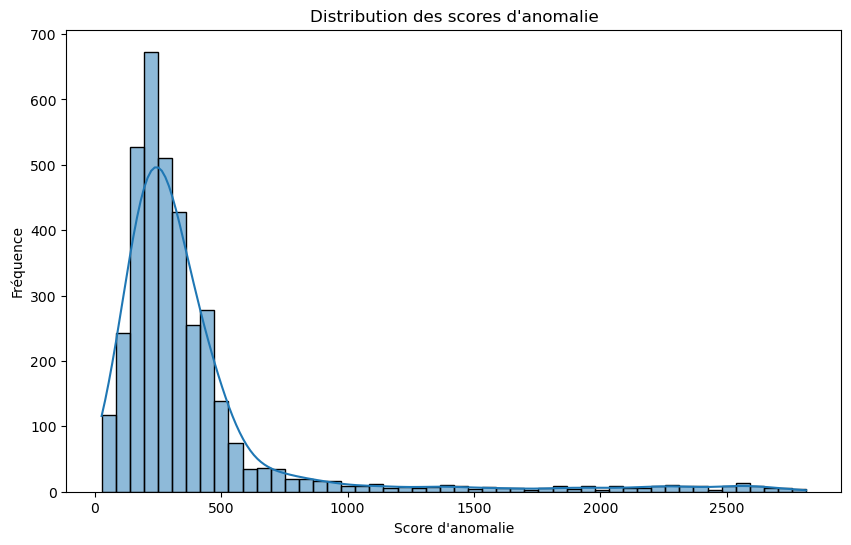

array([ 57.032978,  70.47848 , 303.83435 , ..., 312.88232 , 314.99026 ,
       314.20984 ], dtype=float32)

In [124]:
#TEST TCNP - I.O.
tester = TCNPredictionTester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} : 0.2950 (Temps: 11.18 sec)


Meilleurs hyperparamètres: {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} avec Loss 0.2950
Loss sur l'ensemble de test : 0.29502746939011243


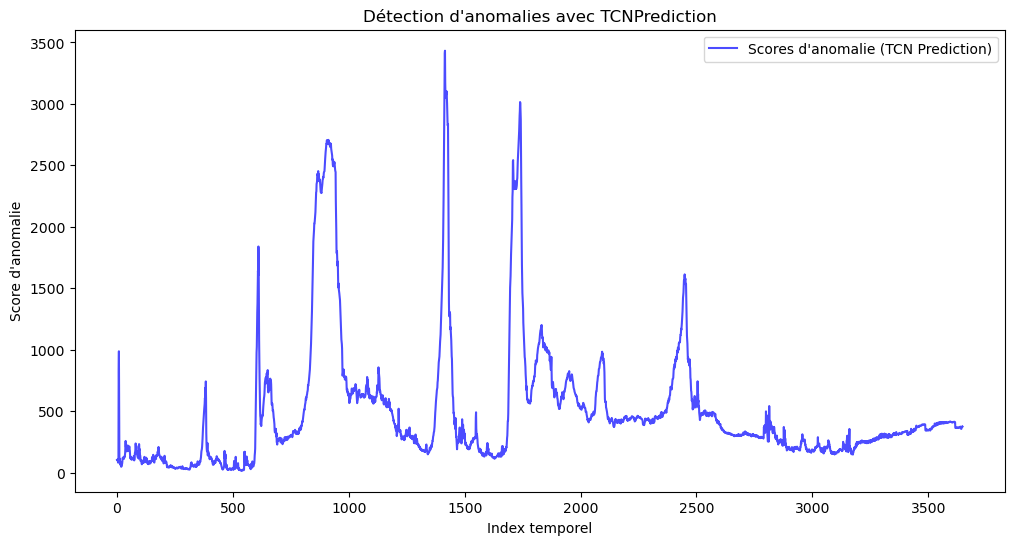

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 152
Ratio d'anomalies : 4.17%


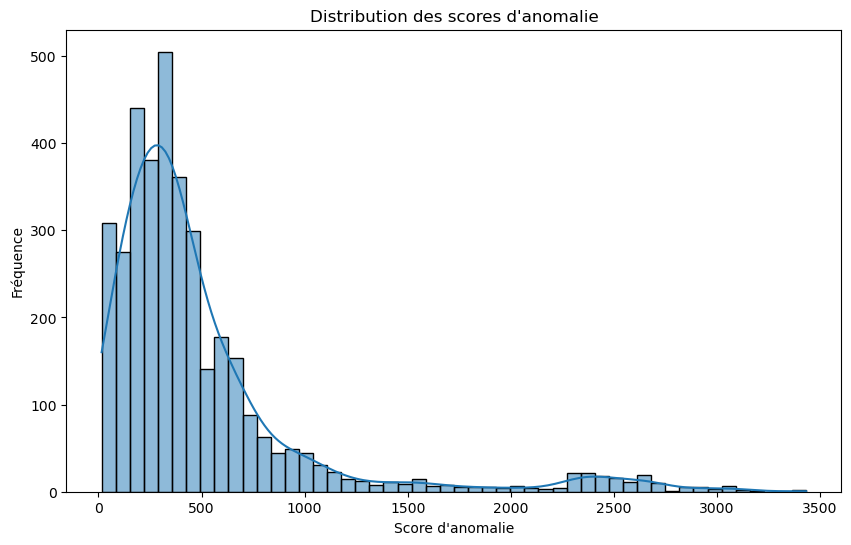

array([102.94842 , 100.268906, 106.038925, ..., 374.63403 , 370.85083 ,
       374.01175 ], dtype=float32)

In [125]:
#TEST TCNP - N.I.O.
tester = TCNPredictionTester(X_train_tensor_nio, X_test_tensor_nio)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

In [23]:
#FONCTIONS TNCS2SP

In [24]:
#CLASS TEST TCNS2SP

Test Loss avec {'filters': (64, 64, 64, 64, 64), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} : 0.1028 (Temps: 35.49 sec)
Test Loss avec {'filters': (32, 32, 32, 32, 32), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} : 0.1613 (Temps: 24.28 sec)

Meilleurs hyperparamètres: {'filters': (64, 64, 64, 64, 64), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} avec Loss 0.10280909613101628
Loss sur l'ensemble de test : 0.10280909613101628


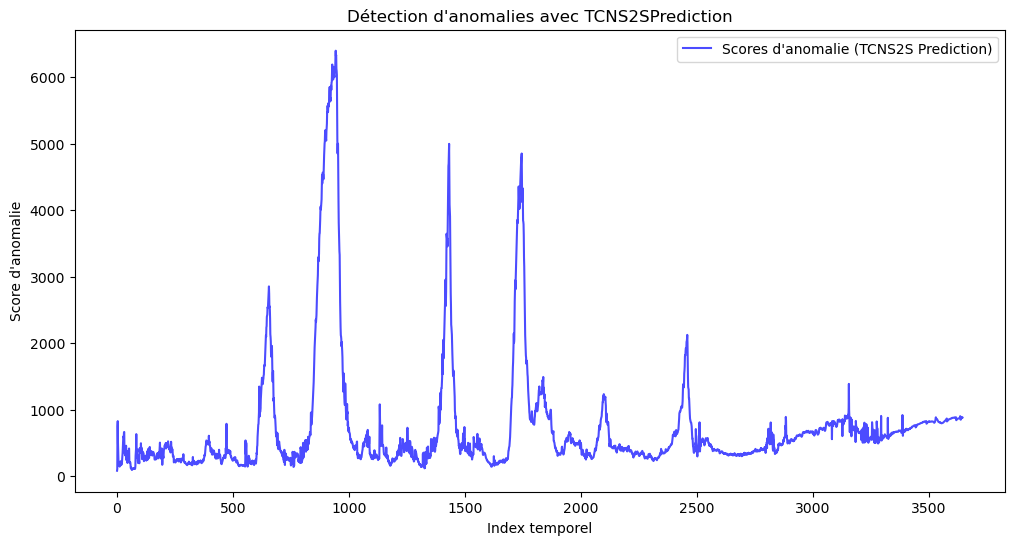

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 133
Ratio d'anomalies : 3.65%


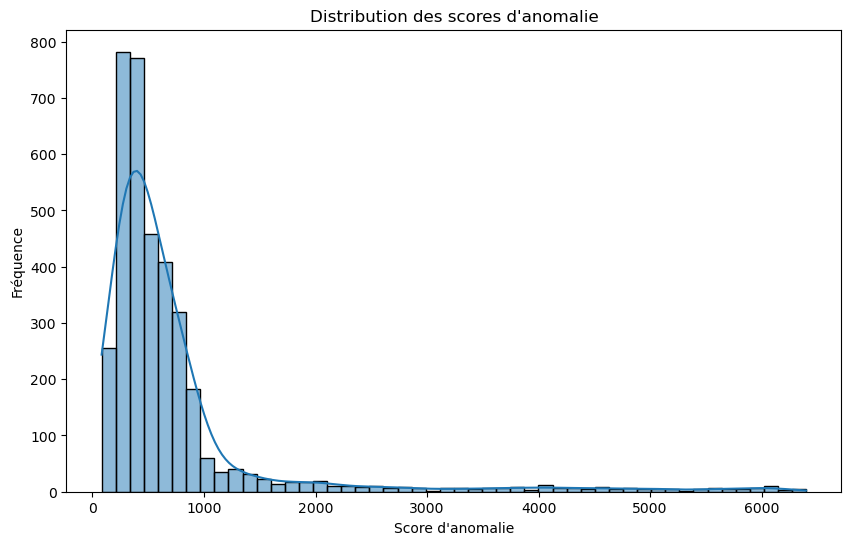

array([ 82.2618 , 109.52144, 750.0241 , ..., 877.6131 , 880.6434 ,
       881.8429 ], dtype=float32)

In [50]:
#TEST TCNS2S ou HE 2019 - I.O.
tester = TCNS2SPredictionTester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

Test Loss avec {'filters': (64, 64, 64, 64, 64), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} : 0.0964 (Temps: 36.75 sec)
Test Loss avec {'filters': (32, 32, 32, 32, 32), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} : 0.2232 (Temps: 24.40 sec)

Meilleurs hyperparamètres: {'filters': (64, 64, 64, 64, 64), 'kernel_sizes': (3, 3, 3, 3, 3), 'dilations': (1, 2, 4, 8, 16), 'last_n_layers_to_cat': 3, 'activation': ReLU(), 'learning_rate': 0.001} avec Loss 0.09635984006783237
Loss sur l'ensemble de test : 0.09635984006783237


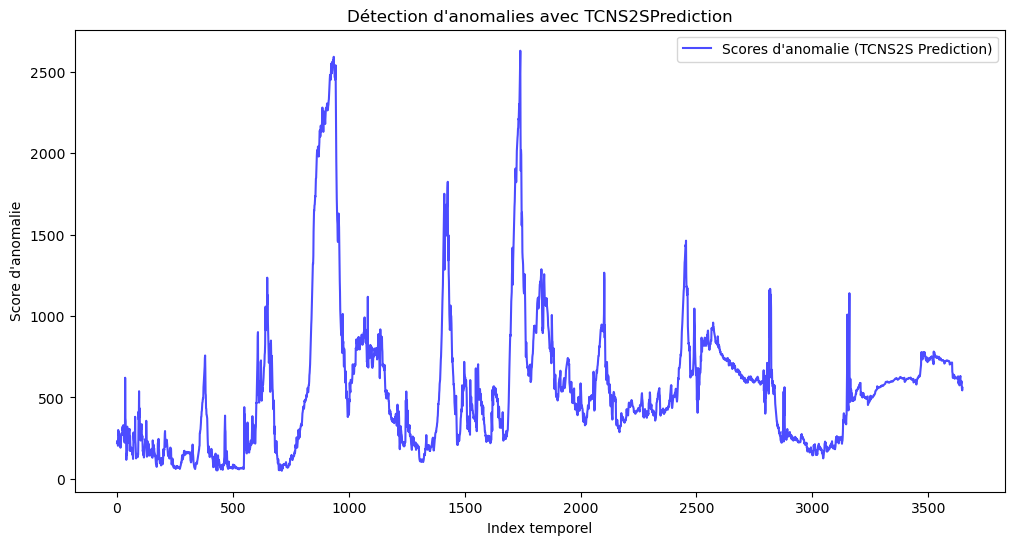

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 114
Ratio d'anomalies : 3.12%


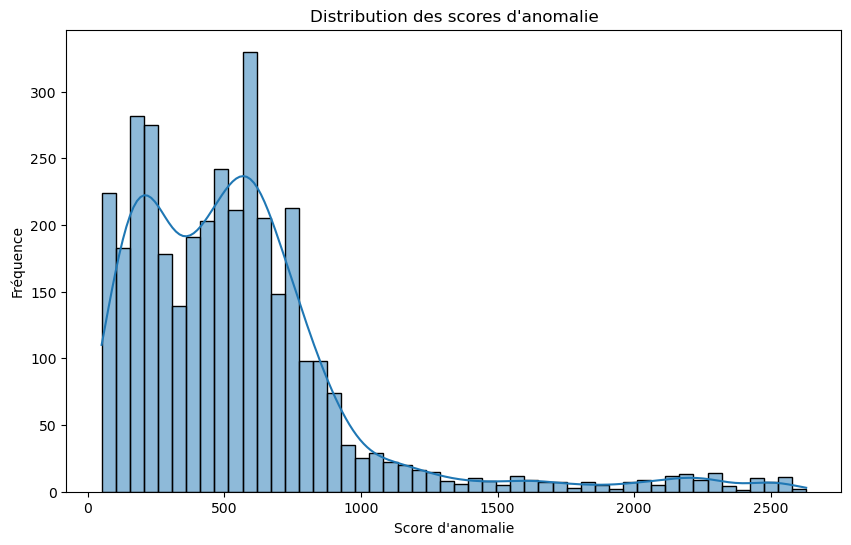

array([219.22792, 231.20503, 225.82445, ..., 546.9864 , 543.5288 ,
       559.4268 ], dtype=float32)

In [51]:
#TEST TCNS2S ou HE 2019 - N.I.O.
tester = TCNS2SPredictionTester(X_train_tensor_nio, X_test_tensor_nio)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

In [36]:
#FONCTIONS LSTMP

In [61]:
#CLASS TEST LSTMP

Test Loss avec {'lstm_hidden_dims': [64, 64, 32], 'linear_hidden_layers': [100, 50], 'linear_activation': ELU(alpha=1.0), 'prediction_horizon': 3, 'learning_rate': 0.001, 'optimizer': 'adam'} : 0.1720 (Temps: 172.76 sec)

Meilleurs hyperparamètres: {'lstm_hidden_dims': [64, 64, 32], 'linear_hidden_layers': [100, 50], 'linear_activation': ELU(alpha=1.0), 'prediction_horizon': 3, 'learning_rate': 0.001, 'optimizer': 'adam'} avec Loss 0.17201530188322067
Loss sur l'ensemble de test : 0.17201530188322067


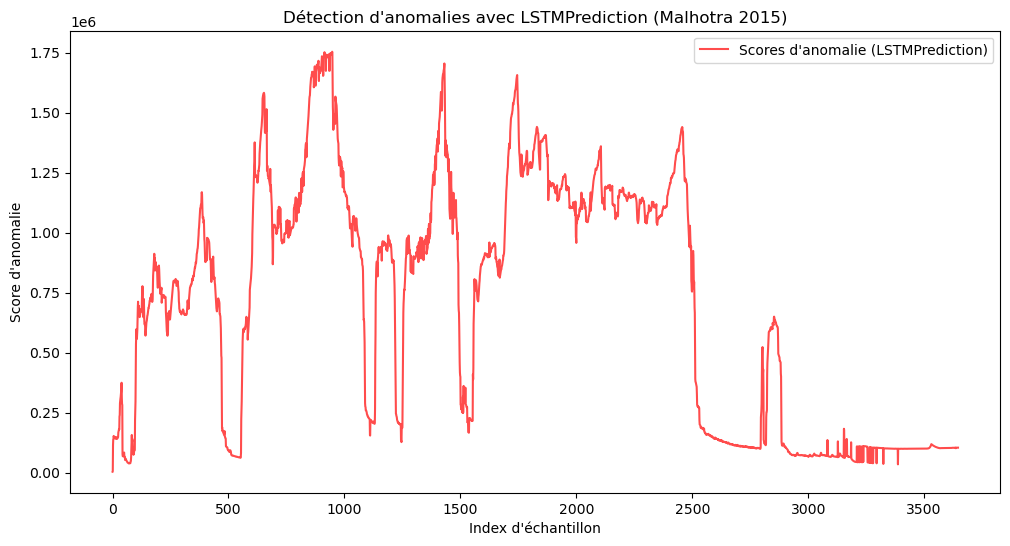

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 0
Ratio d'anomalies : 0.00%


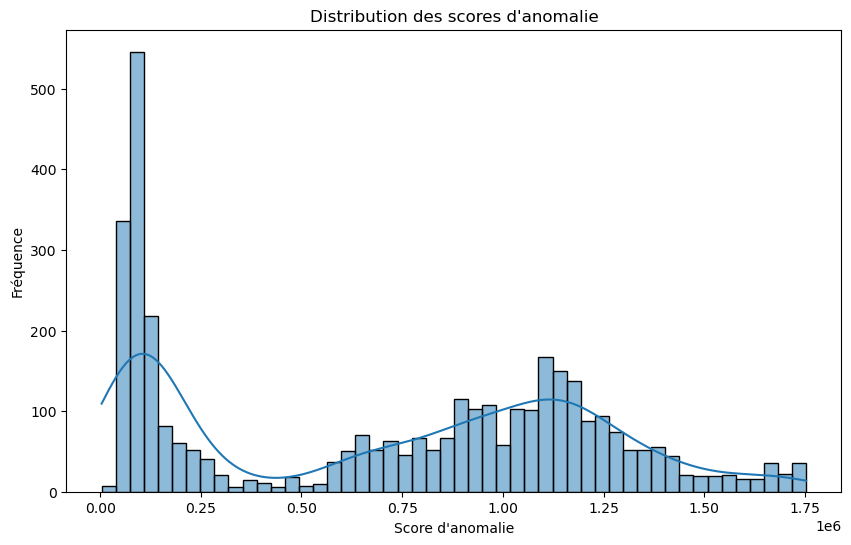

array([  3664.0796,   5833.0312, 113924.63  , ..., 103876.8   ,
       103866.62  , 103881.7   ], dtype=float32)

In [41]:
#TEST LSTMP ou MALHOTRA 2015 - I.O.
tester = LSTMPredictionTester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

Test Loss avec {'lstm_hidden_dims': [64, 64, 32], 'linear_hidden_layers': [100, 50], 'linear_activation': ELU(alpha=1.0), 'prediction_horizon': 3, 'learning_rate': 0.001, 'optimizer': 'adam'} : 0.1966 (Temps: 170.12 sec)

Meilleurs hyperparamètres: {'lstm_hidden_dims': [64, 64, 32], 'linear_hidden_layers': [100, 50], 'linear_activation': ELU(alpha=1.0), 'prediction_horizon': 3, 'learning_rate': 0.001, 'optimizer': 'adam'} avec Loss 0.19658584147691727
Loss sur l'ensemble de test : 0.19658584147691727


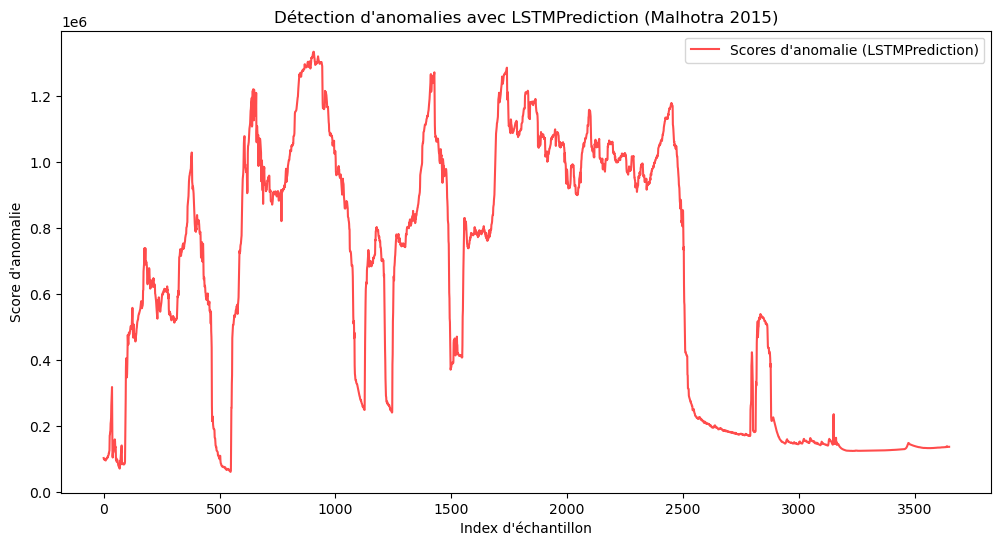

Seuil (Z-score): 3.0000
Nombre d'anomalies détectées : 0
Ratio d'anomalies : 0.00%


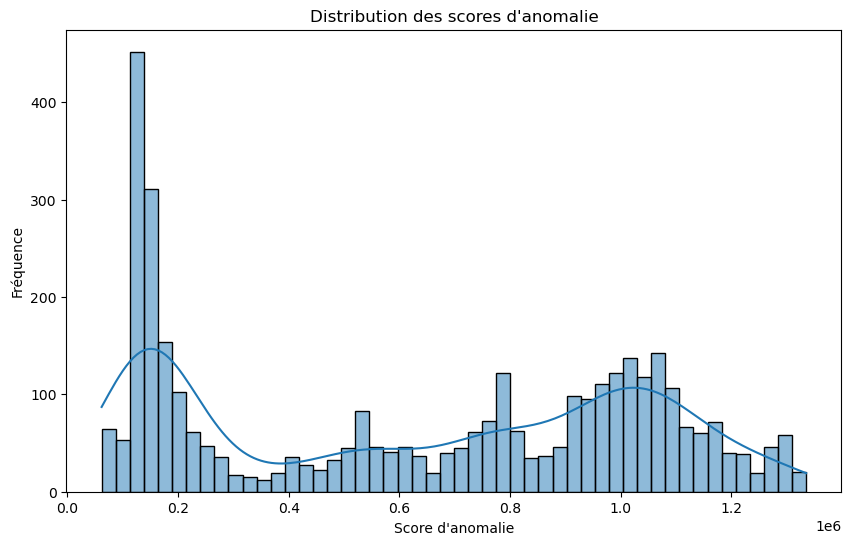

array([103247.67,  99917.  ,  99003.83, ..., 137345.28, 137334.56,
       137332.67], dtype=float32)

In [40]:
#TEST LSTMP ou MALHOTRA 2015 - N.I.O.
tester = LSTMPredictionTester(X_train_tensor_nio, X_test_tensor_nio)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

In [15]:
#FONCTIONS LSTM-AE MIRZA

In [16]:
#CLASS LSTM-AE MIRZA

Test Loss avec {'hidden_dimensions': [32], 'latent_pooling': 'last'} : 0.0226 (Temps: 32.76 sec)
Test Loss avec {'hidden_dimensions': [32], 'latent_pooling': 'mean'} : 0.0210 (Temps: 33.25 sec)
Test Loss avec {'hidden_dimensions': [64], 'latent_pooling': 'last'} : 0.0232 (Temps: 45.28 sec)
Test Loss avec {'hidden_dimensions': [64], 'latent_pooling': 'mean'} : 0.0192 (Temps: 45.36 sec)
Test Loss avec {'hidden_dimensions': [128], 'latent_pooling': 'last'} : 0.0186 (Temps: 87.16 sec)
Test Loss avec {'hidden_dimensions': [128], 'latent_pooling': 'mean'} : 0.0165 (Temps: 85.27 sec)


Meilleurs hyperparamètres: {'hidden_dimensions': [128], 'latent_pooling': 'mean'} avec Loss 0.0165
Test outputs shape: torch.Size([50, 3647, 49])
Loss sur l'ensemble de test : 0.021070461720228195


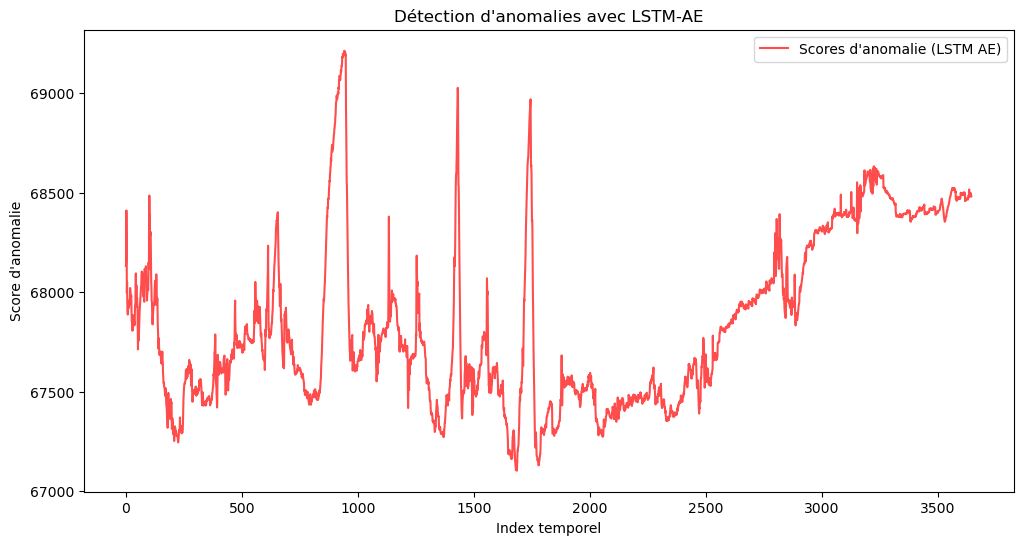

array([[68131.38 ],
       [68154.805],
       [68410.76 ],
       ...,
       [68483.86 ],
       [68482.62 ],
       [68481.875]], dtype=float32)

In [17]:
#TEST MIRZA - I.O.
tester = LSTMAETester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

In [49]:
#TEST MIRZA - N.I.O.
# NE MARCHE PAS AVEC CERTAINS FICHIER 
tester = LSTMAETester(X_train_tensor_nio, X_test_tensor_nio)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [6]:
#FONCTIONS MALHOTRA 2016

In [15]:
#CLASS TEST MALHOTRA 2016

Test Loss avec {'hidden_dimensions': [32]} : 1.2564 (Temps: 31.13 sec)

Meilleurs hyperparamètres: {'hidden_dimensions': [32]} avec Loss 1.2564139911218692
Test outputs shape: torch.Size([50, 3647, 49])
Loss sur l'ensemble de test : 1.256644368171692


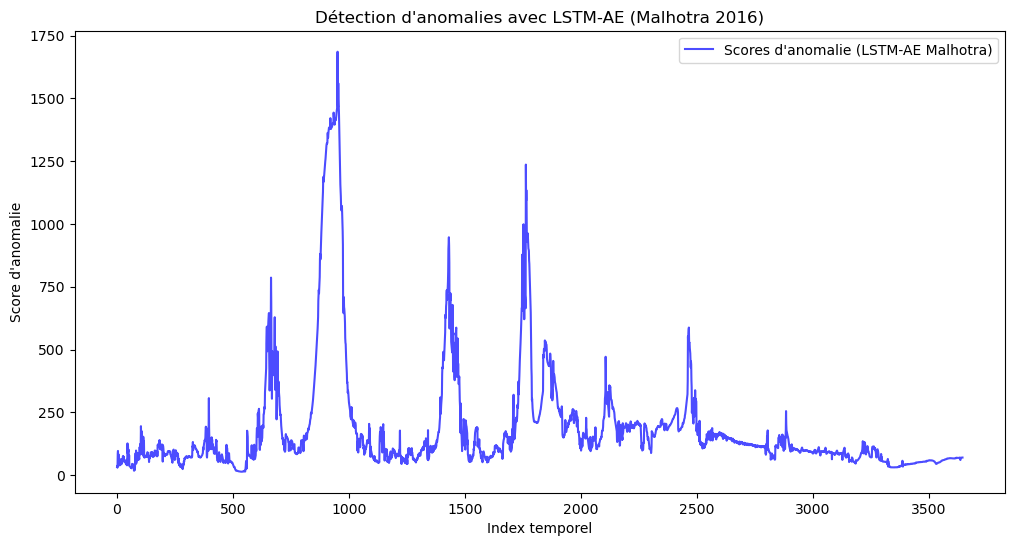

Seuil (Z-score): 5.0000
Nombre d'anomalies détectées : 50
Ratio d'anomalies : 1.37%


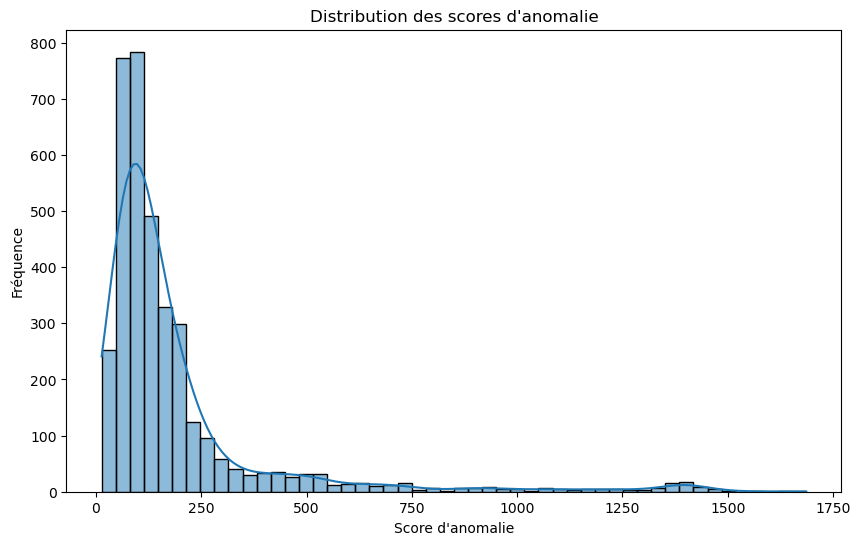

array([32.077675, 37.15815 , 30.387436, ..., 70.102165, 70.07277 ,
       70.05047 ], dtype=float32)

In [16]:
#TEST - I.O.
tester = LSTMAEMALHOTRATester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores() #BUG (ValueError: Per-column arrays must each be 1-dimensional)

Test Loss avec {'hidden_dimensions': [32]} : 1.2098 (Temps: 47.42 sec)

Meilleurs hyperparamètres: {'hidden_dimensions': [32]} avec Loss 1.2097846741261689
Test outputs shape: torch.Size([50, 3649, 45])
Loss sur l'ensemble de test : 1.2148138284683228


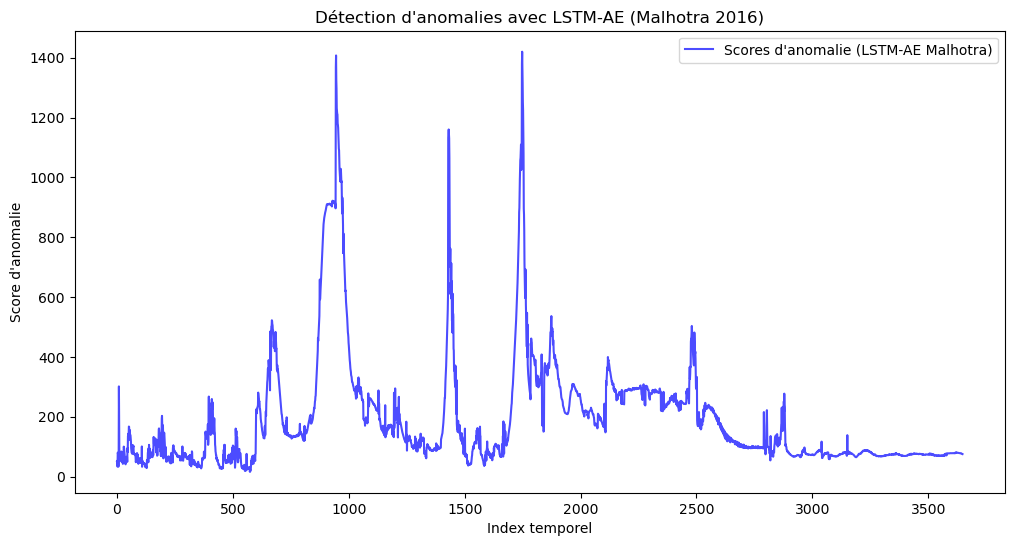

Seuil (Z-score): 5.0000
Nombre d'anomalies détectées : 17
Ratio d'anomalies : 0.47%


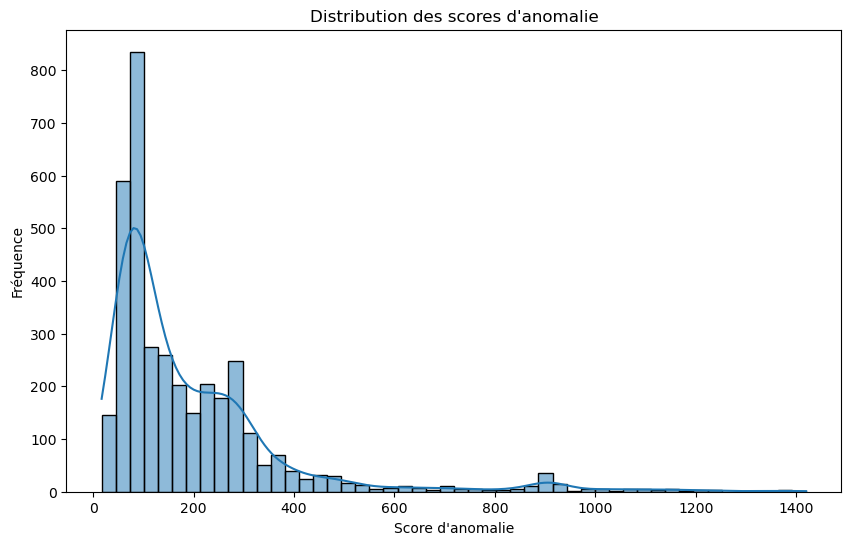

array([52.125244, 53.35803 , 33.79315 , ..., 75.95012 , 75.98045 ,
       75.59326 ], dtype=float32)

In [17]:
#TEST - N.I.O.
tester = LSTMAEMALHOTRATester(X_train_tensor_nio, X_test_tensor_nio)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

X_test_tensor shape: torch.Size([3647, 50, 49])
X_test_tensor transposé shape: torch.Size([50, 3647, 49])
Inputs type: <class 'tuple'>
Inputs shape: torch.Size([32, 50, 49])
Targets shape: torch.Size([32, 50, 49])
Les attributs 'mean' et 'precision' sont correctement initialisés.
Sortie pour tenseur synthétique : torch.Size([32, 50, 49])
Dernier pas de sortie : torch.Size([32, 49])
test_outputs shape: torch.Size([3647, 50, 49])
last_test_outputs shape: torch.Size([3647, 49])
last_targets shape: torch.Size([3647, 49])
Loss sur l'ensemble de test : 0.3787704110145569


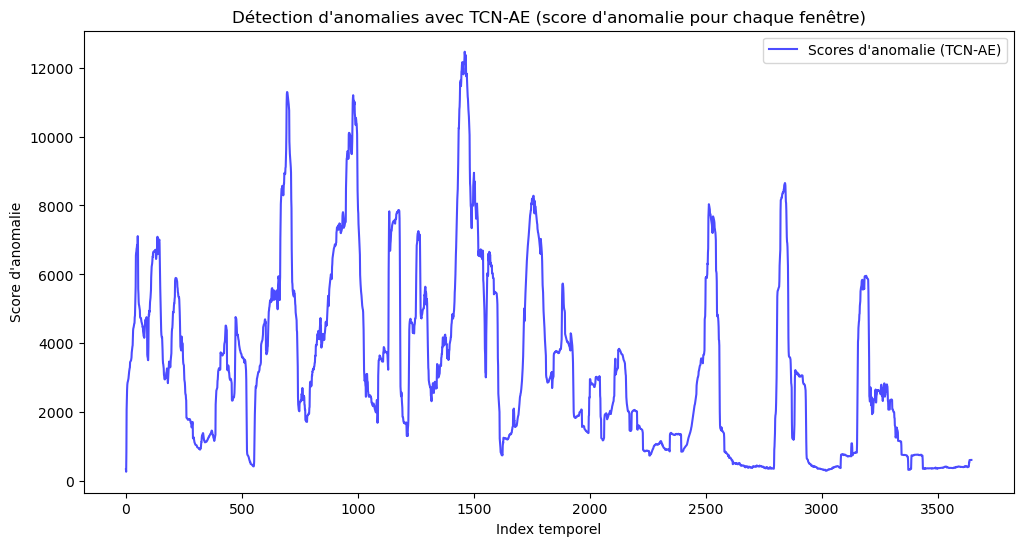

In [18]:
# TEST TCN-AE SANS CLASSE

In [ ]:
#TEST OMNI ANOMALY (TRES LONG DONC MASQUE)

In [16]:
#TEST LSTM VAE GAN : (POSSIBILITE DUTILISER DAUTRES CLASSES de ltsm_vae_gan.py COMME LSTMVAEGANTrainer POUR UN ENTRAINEMENT PLUS POUSSE)
#NE MARCHE PAS POUR LE MOMENT
def collate_fn_lstm_vaegan(batch):
    """
    Pour LSTMVAEGAN, l'entrée attendue est un tenseur de forme (T, B, D) 
    (T: longueur de la séquence, B: batch, D: dimension des features).
    Ici, chaque échantillon est de forme (T, D) et la cible est identique à l’entrée.
    """
    xs, ys = zip(*batch)  # xs et ys sont des tuples de tenseurs de forme (T, D)
    xs = torch.stack(xs, dim=0)         # (B, T, D)
    xs = xs.transpose(0, 1)              # (T, B, D)
    ys = torch.stack(ys, dim=0).transpose(0, 1)  # (T, B, D)
    return (xs,), (ys,)

class LSTMVAEGANTester:
    """
    Cette classe permet de :
      1. Optimiser les hyperparamètres d'un modèle LSTMVAEGAN via un split train/test.
      2. Tester le modèle sur le jeu de test en calculant la loss (ici la reconstruction).
      3. Visualiser le score d'anomalie (calculé sur le dernier pas de temps de chaque séquence).
      
    On suppose que :
      - Le modèle LSTMVAEGAN est défini pour recevoir en entrée un tuple (z, x) où :
            x : tenseur de forme (T, B, D)
            z : tenseur de bruit aléatoire de forme (T, B, latent_dim)
      - Les tenseurs d’entraînement et de test sont de forme (N, T, D) et que la cible
        est égale à l’entrée (auto-encodeur).
    """
    def __init__(self, X_train: torch.Tensor, X_test: torch.Tensor):
        """
        Parameters
        ----------
        X_train : torch.Tensor
            Tenseur d’entraînement de forme (N, T, D)
        X_test : torch.Tensor
            Tenseur de test de forme (N, T, D)
        """
        self.X_train = X_train
        self.X_test = X_test
        self.input_dim = X_train.shape[-1]
        self.sequence_length = X_train.shape[1]

    def optimize_hyperparameters(self, epochs: int = 5, batch_size: int = 32):
        """
        Recherche sur une grille d’hyperparamètres et choisit la configuration qui minimise
        la loss (ici, la MSE entre l’entrée et la reconstruction) sur le jeu de test.
        
        Returns
        -------
        best_model : Le modèle LSTMVAEGAN entraîné avec la meilleure configuration.
        best_params : dict des meilleurs hyperparamètres.
        best_loss : float, la loss correspondante.
        """
        param_grid = {
            'lstm_hidden_dims': [ [60], [128, 64] ],
            'latent_dim': [10, 20],
            'learning_rate': [1e-3]
        }

        best_loss = float('inf')
        best_params = None
        best_model = None

        # Création des datasets
        train_dataset = TensorDataset(self.X_train, self.X_train)
        test_dataset = TensorDataset(self.X_test, self.X_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  collate_fn=collate_fn_lstm_vaegan)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 collate_fn=collate_fn_lstm_vaegan)
        criterion = torch.nn.MSELoss()

        for params in itertools.product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), params))
            start_time = time.time()
            model = LSTMVAEGAN(
                input_dim=self.input_dim,
                lstm_hidden_dims=param_dict['lstm_hidden_dims'],
                latent_dim=param_dict['latent_dim']
            )
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=param_dict['learning_rate'])

            # Entraînement sur quelques époques
            for epoch in range(epochs):
                for (inputs, targets) in train_loader:
                    # inputs est un tuple (x,) où x a pour forme (T, B, D)
                    x, = inputs
                    T, B, _ = x.shape
                    # Générer un vecteur de bruit aléatoire de forme (T, B, latent_dim)
                    z = torch.randn(T, B, param_dict['latent_dim'], device=x.device, dtype=x.dtype)
                    optimizer.zero_grad()
                    # La passe avant retourne (z_mu, z_log_var, x, x_rec, x_score, x_rec_score, x_gen_score)
                    outputs = model((z, x))
                    x_rec = outputs[3]
                    loss = criterion(x, x_rec)
                    loss.backward()
                    optimizer.step()

            # Évaluation sur le jeu de test
            model.eval()
            total_loss = 0
            with torch.no_grad():
                for (inputs, targets) in test_loader:
                    x, = inputs
                    T, B, _ = x.shape
                    z = torch.randn(T, B, param_dict['latent_dim'], device=x.device, dtype=x.dtype)
                    outputs = model((z, x))
                    x_rec = outputs[3]
                    loss = criterion(x, x_rec)
                    total_loss += loss.item()
            test_loss = total_loss / len(test_loader)
            elapsed_time = time.time() - start_time
            print(f"Test Loss avec {param_dict} : {test_loss:.4f} (Temps: {elapsed_time:.2f} sec)")

            if test_loss < best_loss:
                best_loss = test_loss
                best_params = param_dict
                best_model = model

        print("\nMeilleurs hyperparamètres :", best_params, f"avec Loss {best_loss:.4f}")
        self.best_model = best_model
        self.best_params = best_params
        self.best_loss = best_loss
        return best_model, best_params, best_loss

    def test_model(self, batch_size: int = 32) -> float:
        """
        Évalue le modèle optimisé sur le jeu de test en calculant la loss (MSE entre
        l’entrée et la reconstruction).
        
        Returns
        -------
        test_loss : float
            La loss moyenne sur le jeu de test.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")
        test_dataset = TensorDataset(self.X_test, self.X_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 collate_fn=collate_fn_lstm_vaegan)
        criterion = torch.nn.MSELoss()
        total_loss = 0
        self.best_model.eval()
        with torch.no_grad():
            for (inputs, targets) in test_loader:
                x, = inputs
                print("Forme de x (cible) :", x.shape)
                T, B, _ = x.shape
                latent_dim = self.best_params['latent_dim']
                z = torch.randn(T, B, latent_dim, device=x.device, dtype=x.dtype)
                outputs = self.best_model((z, x))
                x_rec = outputs[3]
                print("Forme de x_rec (reconstruction) :", x_rec.shape)
                loss = criterion(x, x_rec)
                total_loss += loss.item()
        test_loss = total_loss / len(test_loader)
        print(f"Loss sur l'ensemble de test : {test_loss:.4f}")
        self.test_loss = test_loss
        return test_loss

    def plot_anomaly_scores(self):
        """
        Calcule et affiche le score d'anomalie pour chaque échantillon de X_test.
        Pour chaque fenêtre, le score est calculé à partir de :
          - Le score du discriminateur sur le dernier pas de temps.
          - Le score de reconstruction (somme des erreurs absolues) sur le dernier pas.
        Le score final est une combinaison linéaire de ces deux termes.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")

        # On encapsule le modèle optimisé dans le détecteur d'anomalies LSTMVAEGAN
        anomaly_detector = LSTMVAEGANAnomalyDetector(self.best_model)
        anomaly_scores = []

        # On itère sur chaque fenêtre (échantillon) de X_test
        for i in range(len(self.X_test)):
            x = self.X_test[i]        # forme (T, D)
            x = x.unsqueeze(1)         # forme (T, 1, D)
            with torch.no_grad():
                score = anomaly_detector.compute_online_anomaly_score((x,))
            anomaly_scores.append(score.item())
        anomaly_scores = np.array(anomaly_scores)

        plt.figure(figsize=(12, 6))
        plt.plot(anomaly_scores, label="Anomaly Score (LSTMVAEGAN)")
        plt.title("Détection d'anomalies avec LSTMVAEGAN")
        plt.xlabel("Index de l'échantillon")
        plt.ylabel("Score d'anomalie")
        plt.legend()
        plt.show()

        self.anomaly_scores = anomaly_scores
        return anomaly_scores

In [18]:
#TEST LSTMVAEGAN - I.O.
tester = LSTMVAEGANTester(X_train_tensor, X_test_tensor)
best_model, best_params, best_loss = tester.optimize_hyperparameters()
test_loss = tester.test_model(batch_size=32)
anomaly_scores = tester.plot_anomaly_scores()

Forme de rnn_out : torch.Size([50, 32, 60])
Forme de la reconstruction (mean) : torch.Size([50, 32, 49])
Forme de rnn_out : torch.Size([50, 32, 60])
Forme de la reconstruction (mean) : torch.Size([50, 32, 49])
Forme de x_rec avant passage dans le discriminator : torch.Size([50, 32, 60])


RuntimeError: The size of tensor a (49) must match the size of tensor b (60) at non-singleton dimension 2

In [9]:
#TEST LSTMVAEGAN - N.I.O.
tester = LSTMVAEGANTester(X_train_tensor_nio, X_test_tensor_nio)
best_model, best_params, best_loss = tester.optimize_hyperparameters(epochs=5, batch_size=32)
test_loss = tester.test_model(batch_size=32)
anomaly_scores = tester.plot_anomaly_scores()

Forme de rnn_out : torch.Size([50, 32, 60])
Forme de la reconstruction (mean) : torch.Size([50, 32, 45])
Forme de rnn_out : torch.Size([50, 32, 60])
Forme de la reconstruction (mean) : torch.Size([50, 32, 45])
Forme de x_rec avant passage dans le discriminator : torch.Size([50, 32, 60])


C:\Users\pellerinc\AppData\Local\anaconda3\envs\timesead_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([50, 32, 60])) that is different to the input size (torch.Size([50, 32, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (45) must match the size of tensor b (60) at non-singleton dimension 2